# A4 - Combine all in One report

Mingxia Li

Statement: except the code labeled "used from example", all other codes are done by myself

## Answer Questions

### 1. What is the question?

This dataset provides user information such as gender, age, occupation, etc., as well as product information such as product category and product ID. Here, what I am trying to do is to **predict the amount of money** that a certain user will buy based on these features.

### 2. What did you do?

In this assignment, I first performed preliminary analyses of the data. These analyses include data type check, missing or outlier check, data distribution and feature correlation analyses, etc.

Next, I completed feature engineering and feature selection. After I removed the outliers, I tried to explore the effects of 3 data impute techniques. After that I used label encode or one-hot encode to convert the categorical features into numerical features for easy use as model input. And a preliminary feature ranking was performed using correlation coefficients.

Then I trained the prediction model using XGBoost algorithm based on tree model and performed hyperparameter tuning step by step using GridSearch framework, although this model did not work very well, I could still use it to filter features. I trained another prediction model after droping the 3 features with the lowest feature importance. The experiments showed that the prediction effect of this model did not improve. I then trained the model using the H2O AutoML framework, from which I selected the best model based on a specific algorithm and performed the prediction.

Finally, I analyzed the XGBoost model globally and locally using SHAP-value. Finally the best model was interpreted using the H2O AutoML framework.

### 3. How well did it work?

Based on the same dataframe, I trained two models, XGBoost and H2O AutoML. The R square value of the XGBoost model is 0.634, which shows that our model is effective, although not that good. The optimal model obtained using the H2O AutoML framework has an R square value of 0.77, which is a significant improvement over the XGBoost model. The improvement is mainly due to some features of the H2O autoML framework. For example, H2O AutoML uses ensemble learning to combine the predictions of multiple models, which can help to reduce overfitting and improve the generalization performance of the model.


### 4. What did you learn?

Through this assignment, I have not only mastered the basic idea of using machine learning algorithms to analyze real-world problems. I learned some more in-depth statistics, such as SHAP value analysis used to explain the model, which allowed me to gain a deeper understanding of how the model works.

## Abstract

A retail company “ABC Private Limited” wants to understand the customer purchase behavior (specifically, purchase amount) against various products of different categories. They have shared purchase summaries of various customers for selected high-volume products from last month. The data set also contains customer demographics (age, gender, marital status, city type, stayincurrentcity), product details (productid and product category), and Total purchase amount from last month. Now, they want to build a model to predict the purchase amount of customers against various products which will help them to create a personalized offer for customers against different products.

## Aim

In this assignment we aim to create a complete ML project with

- Checking Data Quality
- Feature Selection
- Modeling - Training Models, Selecting Best Model, Hyperparameter Tuning
- Model Interpretibility

In [1]:
%%capture
!pip3 install requests
!pip3 install tabulate
!pip3 install future
!pip3 install matplotlib

!pip3 install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
    
!pip3 install graphviz
!pip3 install eli5
!pip3 install lime

In [50]:
import warnings
warnings.filterwarnings("ignore")

import psutil
import random
import logging, sys, os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

import xgboost
from xgboost import XGBRegressor

import statsmodels.formula.api as smf

import sklearn
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import shap
from shap import TreeExplainer, Explainer, waterfall_plot, Explanation
os.environ["PATH"] += os.pathsep + 'E:\Graphviz\bin'

import eli5
from eli5.sklearn import PermutationImportance

import lime
import lime.lime_tabular

## Dataset

Dataset Link: https://www.kaggle.com/datasets/rajeshrampure/black-friday-sale


|  Field Name   | Meaning  |
|  ----  | ----  |
| User_ID  | User ID |
| Product_ID  | Product ID |
| Gender  | Sex of User |
| Age  | Age |
| City_Category  | Category of the City (A, B, C) |
| Occupation  | Occupation (Masked) |
| Stay_In_Current_City_Years  | Number of years stay in current city |
| Marital_Status  | Marital Status |
| Product_Category_1  | Product Category (Masked) |
| Product_Category_2  | Product may belong to other categories also (Masked) |
| Product_Category_3  | Product may belong to other categories also (Masked) |
| Purchase  | Purchase Amount (Target Variable) |

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/alicelmx/6105-Assignments/main/assignment1/right.csv")

## Evaluation Scheme

**R-squared value**:  a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

## Step1: EDA - Checking Data Quality

### Missing Value

Shown as below, there are missing values in Product_Category_2 and Product_Category_3.
This matches the reality, which means it is not required to impute or remove the null values from the data. Because of definitions of these two variables, some products only belong to certain one category.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  int64  
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  int64  
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 50.4+ MB


Text(0.5, 1.0, 'Null Values')

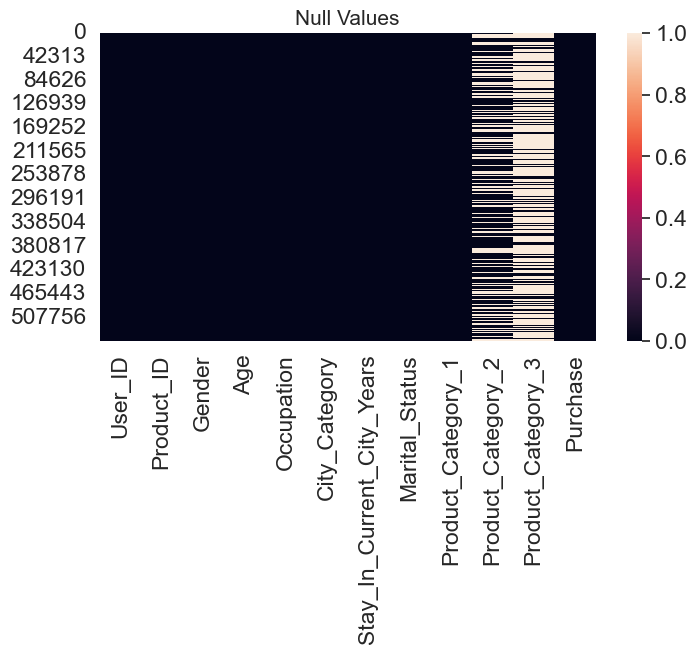

In [5]:
plt.figure(figsize = (8,4))
sns.heatmap(data.isnull())
plt.title("Null Values", fontsize = 15)

In [6]:
print("Product_Category_2 missing data count is " + str(data["Product_Category_2"].isnull().sum()))
print("Product_Category_3 missing data count is " + str(data["Product_Category_3"].isnull().sum()))

#% of missing data in training dataset
print(
    "Percent of Missing Data in Train Data Item Weight Coloumn = "
    + str((data["Product_Category_2"].isnull().sum() / len(data)) * 100)
    + " %"
)
print(
    "Percent of Missing Data in Train Data Outlet Size Coloumn = "
    + str((data["Product_Category_3"].isnull().sum() / len(data)) * 100)
    + " %"
)

Product_Category_2 missing data count is 173638
Product_Category_3 missing data count is 383247
Percent of Missing Data in Train Data Item Weight Coloumn = 31.56664266963357 %
Percent of Missing Data in Train Data Outlet Size Coloumn = 69.67265865311198 %


### Outlier Detection

As we can see in the below table and pie charts, most the values of variables are within reasonable range, which can tell that the predictor variables basicly make sense. Only field "Age" have min value of -55, which is impossible. I guess that thses outliers might caused by human factors like miswriting.

In [7]:
data.describe()

User_ID            Age     Occupation  Stay_In_Current_City_Years  \
count  5.500680e+05  550068.000000  550068.000000               550068.000000   
mean   1.003029e+06      34.559611       8.076707                    4.632224   
std    1.727592e+03      11.773631       6.522660                    8.566609   
min    1.000001e+06     -55.000000       0.000000                    0.000000   
25%    1.001516e+06      27.000000       2.000000                    1.000000   
50%    1.003077e+06      33.000000       7.000000                    2.000000   
75%    1.004478e+06      42.000000      14.000000                    3.000000   
max    1.006040e+06      70.000000      20.000000                   40.000000   

       Marital_Status  Product_Category_1  Product_Category_2  \
count   550068.000000       550068.000000       376430.000000   
mean         0.409653            5.404270            9.842329   
std          0.491770            3.936211            5.086590   
min          0.000000            1.000000            2.000000   
25%          0.000000            1.000000            5.000000   
50%          0.000000            5.000000            9.000000   
75%          1.000000            8.000000           15.000000   
max          1.000000           20.000000           18.000000   

       Product_Category_3       Purchase  
count       166821.000000  550068.000000  
mean            12.668243    9263.968713  
std              4.125338    5023.065394  
min              3.000000      12.000000  
25%              9.000000    5823.000000  
50%             14.000000    8047.000000  
75%             16.000000   12054.000000  
max             18.000000   23961.000000

<Axes: xlabel='Age'>

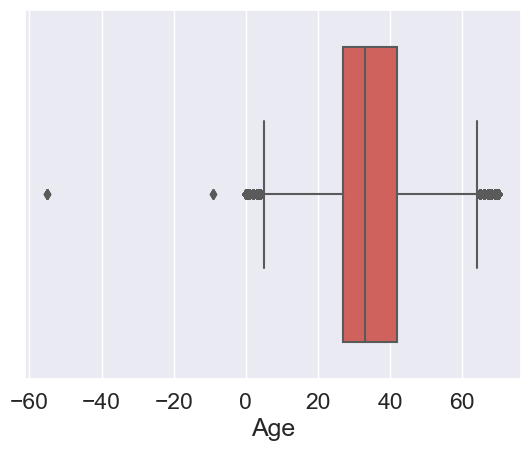

In [8]:
sns.boxplot(x=data["Age"])

<Axes: xlabel='Stay_In_Current_City_Years'>

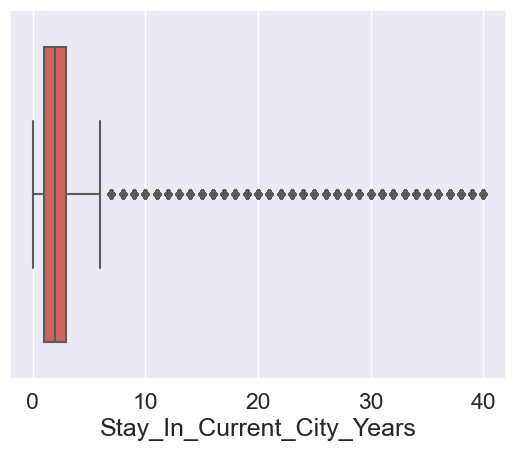

In [9]:
sns.boxplot(x=data["Stay_In_Current_City_Years"])

most people have lived in this city for less than 6 years, but there are minority have lived for 5+. It is normal situation that I won't treat them as outliers.

### Data Distribution

array([<Axes: ylabel='User_ID'>], dtype=object)

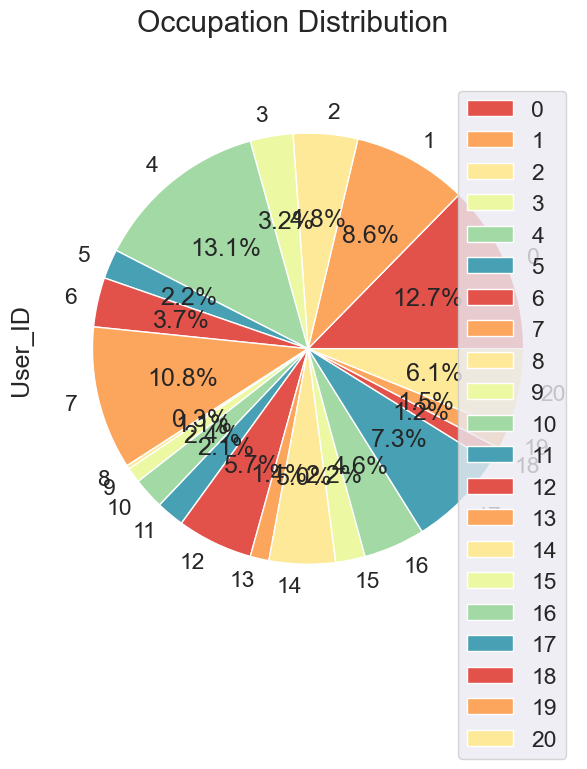

In [10]:
# Analysis by Occupation
occupation_count = data[['Occupation','User_ID']].groupby('Occupation').count()
occupation_count
occupation_count.plot(kind='pie', autopct='%1.1f%%', subplots=True, title='Occupation Distribution', figsize=(12,7))

array([<Axes: ylabel='User_ID'>], dtype=object)

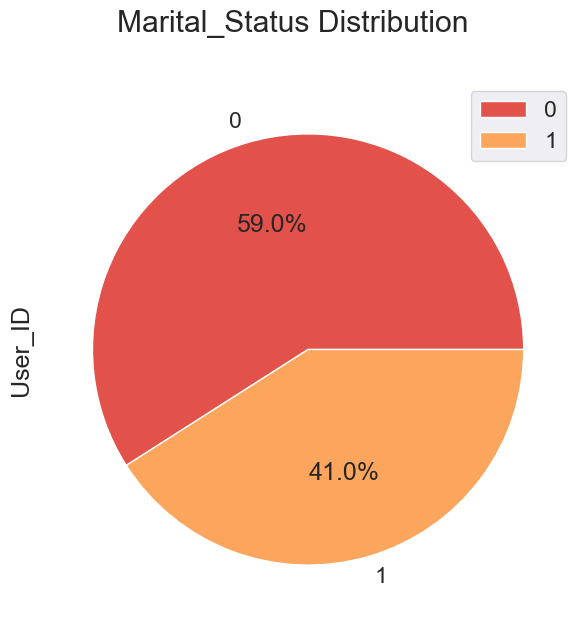

In [11]:
# Analysis by Marital_Status
occupation_count = data[['Marital_Status','User_ID']].groupby('Marital_Status').count()
occupation_count
occupation_count.plot(kind='pie', autopct='%1.1f%%', subplots=True, title='Marital_Status Distribution', figsize=(12,7))

array([<Axes: ylabel='User_ID'>], dtype=object)

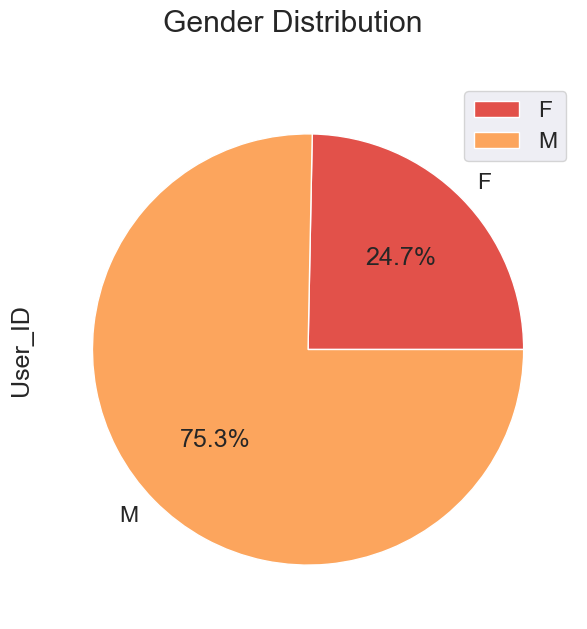

In [12]:
# Analysis by Gender
gender_count = data[['Gender','User_ID']].groupby('Gender').count()
gender_count
gender_count.plot(kind='pie', autopct='%1.1f%%', subplots=True, title='Gender Distribution', figsize=(12,7))

array([<Axes: ylabel='User_ID'>], dtype=object)

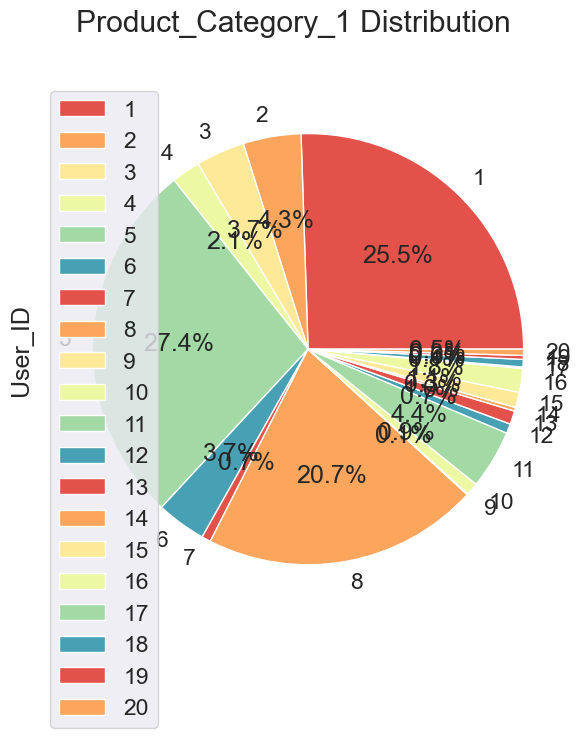

In [13]:
# Analysis by Product_Category_1
product_category_1_count = data[['Product_Category_1','User_ID']].groupby('Product_Category_1').count()
product_category_1_count
product_category_1_count.plot(kind='pie', autopct='%1.1f%%', subplots=True, title='Product_Category_1 Distribution', figsize=(12,7))

array([<Axes: ylabel='User_ID'>], dtype=object)

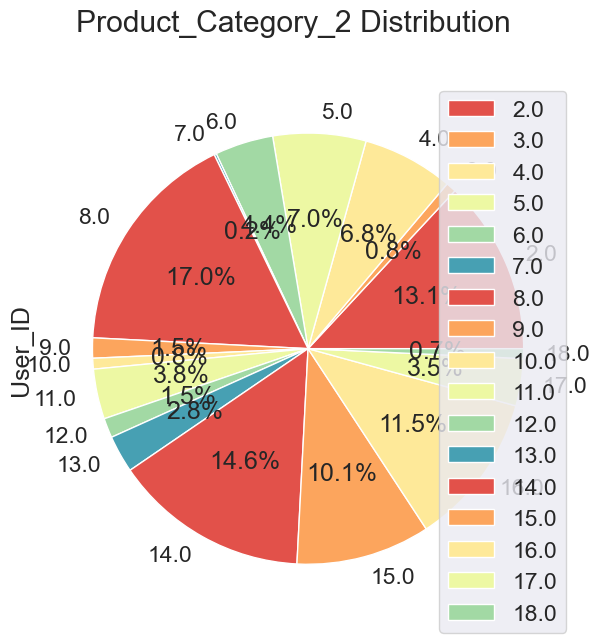

In [14]:
# Analysis by Product_Category_2
product_category_2_count = data[['Product_Category_2','User_ID']].groupby('Product_Category_2').count()
product_category_2_count
product_category_2_count.plot(kind='pie', autopct='%1.1f%%', subplots=True, title='Product_Category_2 Distribution', figsize=(12,7))

array([<Axes: ylabel='User_ID'>], dtype=object)

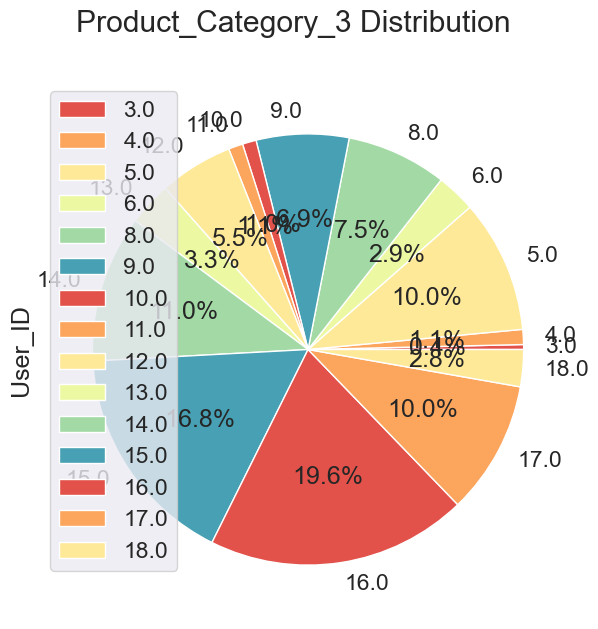

In [15]:
# Analysis by Product_Category_3
product_category_3_count = data[['Product_Category_3','User_ID']].groupby('Product_Category_3').count()
product_category_3_count
product_category_3_count.plot(kind='pie', autopct='%1.1f%%', subplots=True, title='Product_Category_3 Distribution', figsize=(12,7))

Text(0.5, 0, 'Skewness -->  0.36, Kurtosis --> 0.22')

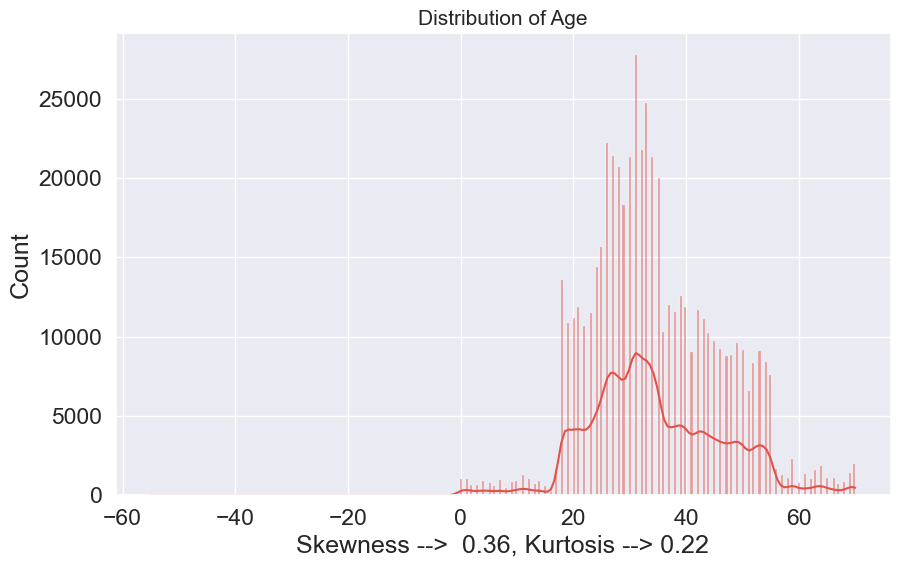

In [16]:
# Age
plt.figure(figsize = (10,6))
sns.histplot(data.Age, kde = True)
plt.title("Distribution of Age", fontsize = 15)
plt.xlabel("Skewness -->  {:.2f}, Kurtosis --> {:.2f}".format(data.Age.skew(), data.Age.kurtosis()))

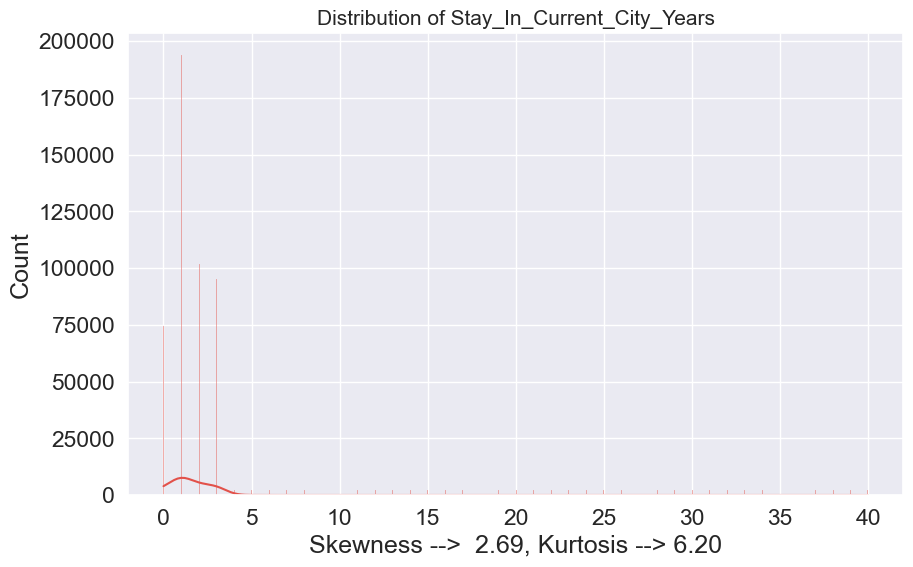

In [17]:
# Stay_In_Current_City_Years
plt.figure(figsize = (10,6))
sns.histplot(data.Stay_In_Current_City_Years, kde = True)
plt.title("Distribution of Stay_In_Current_City_Years", fontsize = 15)
plt.xlabel("Skewness -->  {:.2f}, Kurtosis --> {:.2f}".format(data.Stay_In_Current_City_Years.skew(), data.Stay_In_Current_City_Years.kurtosis()));


According to the two figures below, most of the purchases are between 5000 and 10k, we have some outliers purchases above 20000. It appears that it is roughly following normal distribution

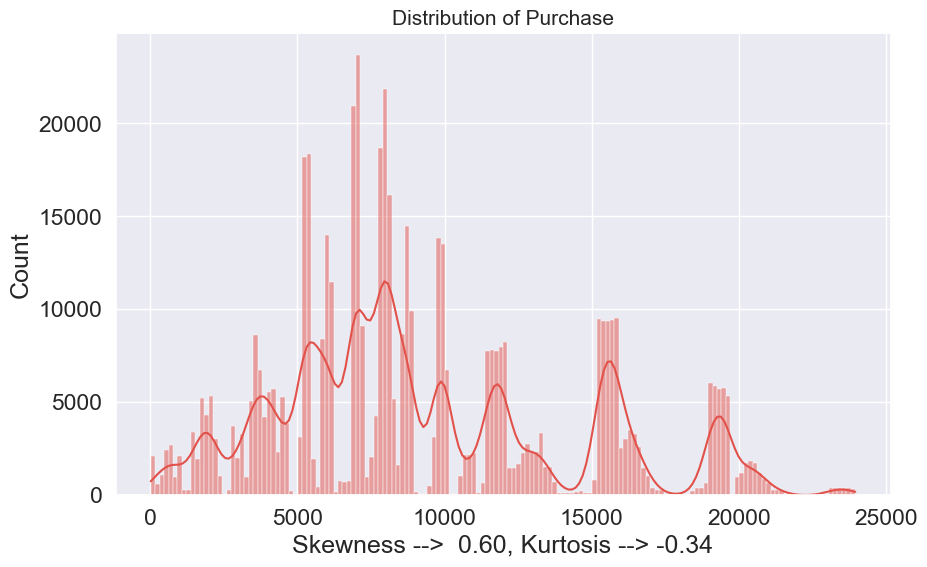

In [18]:
# Plotting the distribution of Purchase
plt.figure(figsize = (10,6))
sns.histplot(data.Purchase, kde = True)
plt.title("Distribution of Purchase", fontsize = 15)
plt.xlabel("Skewness -->  {:.2f}, Kurtosis --> {:.2f}".format(data.Purchase.skew(), data.Purchase.kurtosis()));

### Correlation Check

Correlation matrix shows that there is multicollinearity between the independent variables. According to heatmap, darker the color is, higher corrlation between them. So, heighest correlation is among Product_Category_1, Product_Category_2 and Product_Category_3.

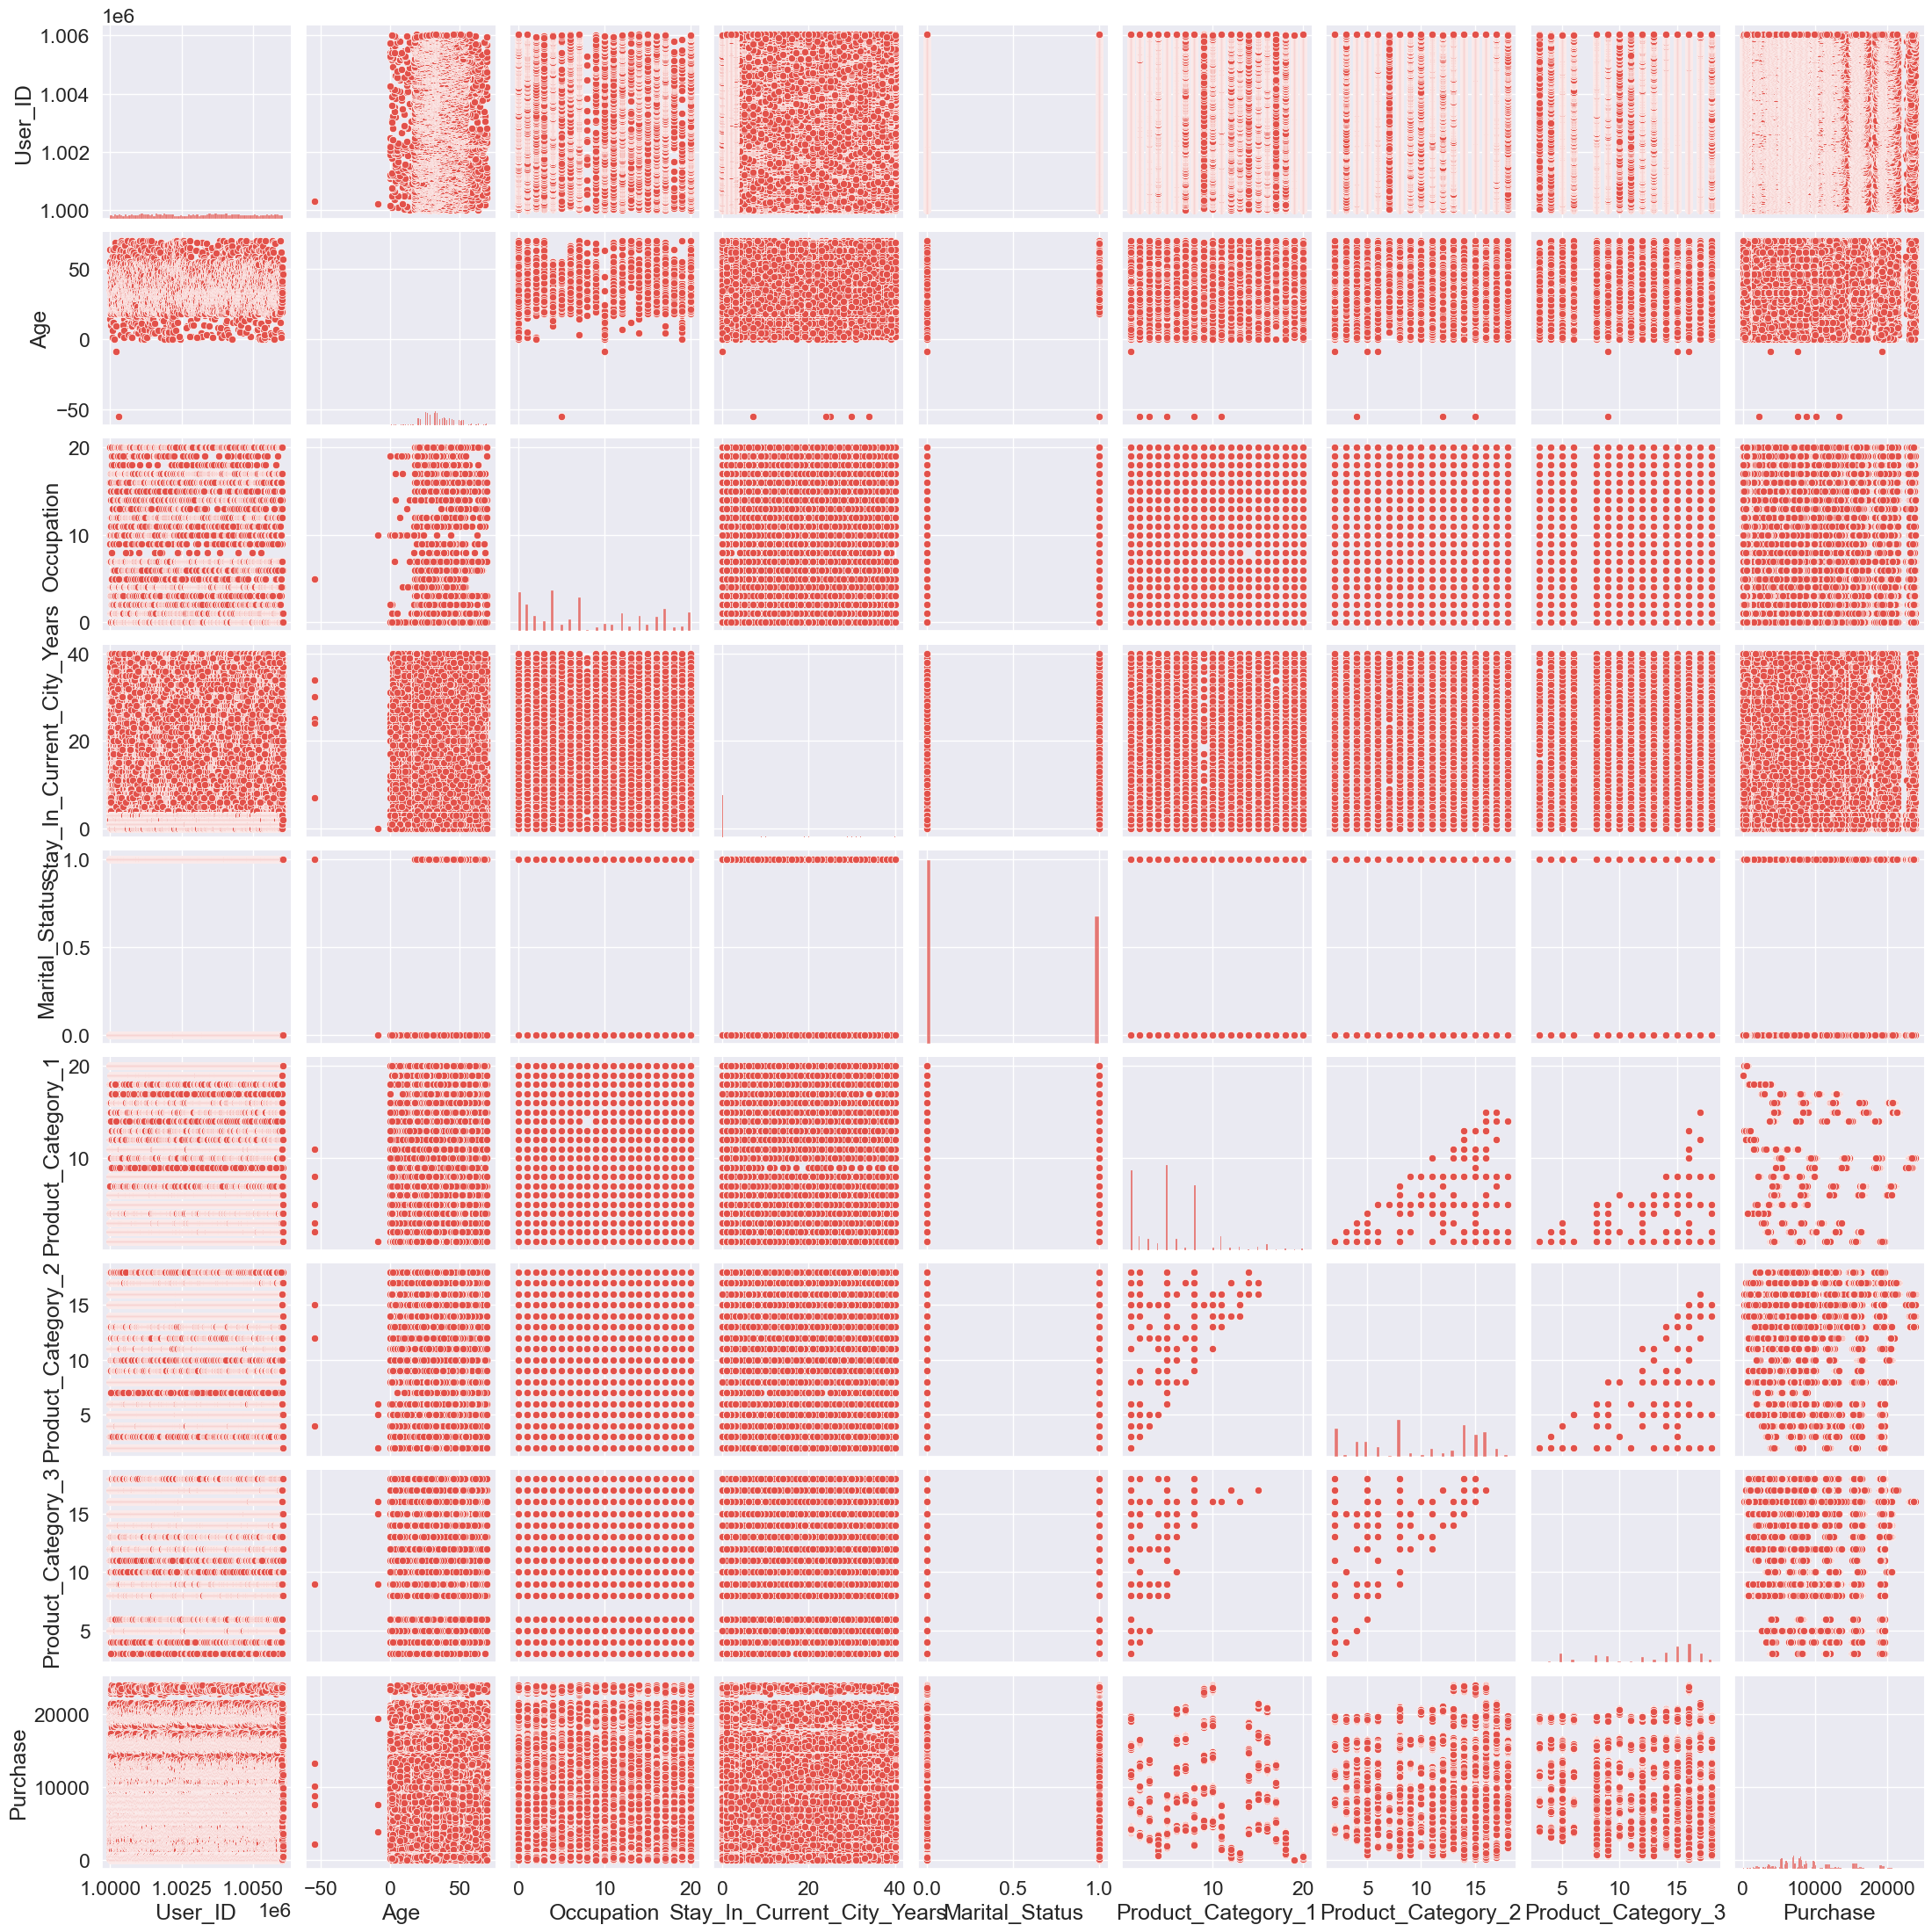

In [19]:
sns.pairplot(data)
# From this plot we can figure out if our data has any colinearity in our data, as we can see in the below plot that our dataset doesn't have any significant colinearity

Text(0.5, 1.0, 'Correlation')

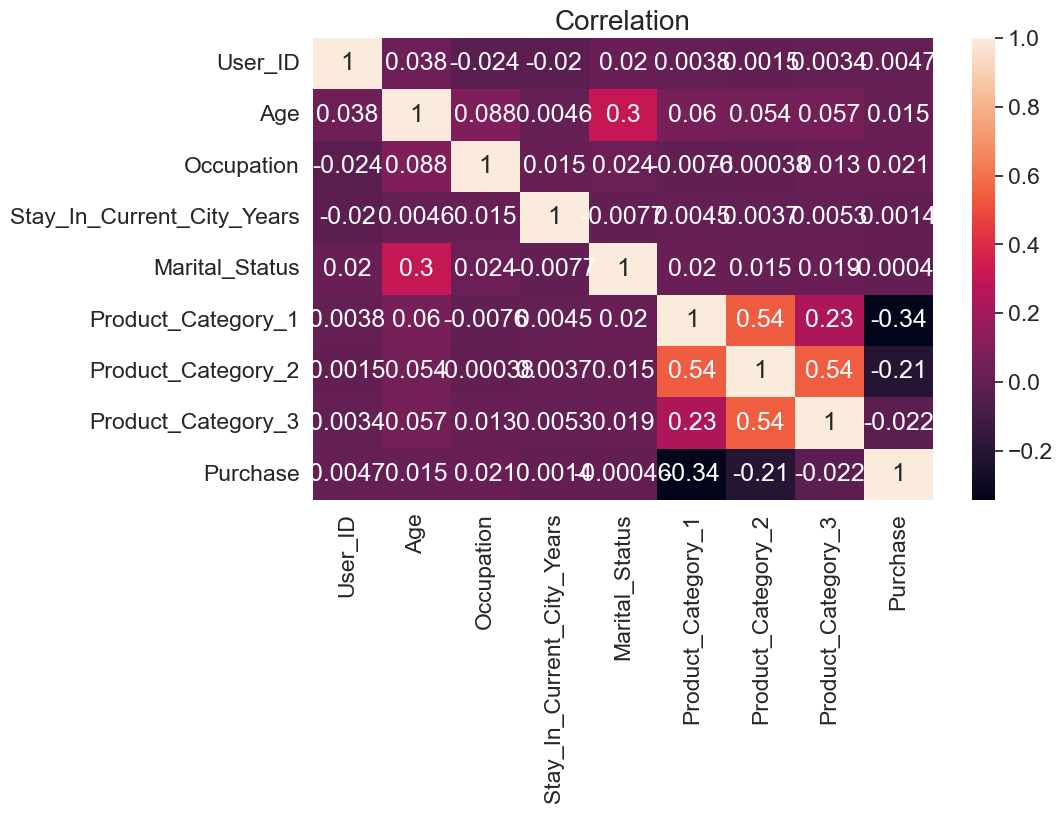

In [20]:
plt.figure(figsize = (10,6))
sns.heatmap(data.corr(), annot = True)
plt.title("Correlation", fontsize = 20)

## Step2: Feature Engineering and Feature Selection

### Remove Outliers

In [21]:
# As we discussed above,there are outliers caused by human factors in field "Age", I will remove them.
data_no_outliers = data[data['Age'] >= 0]
data_no_outliers.head()

User_ID Product_ID Gender  Age  Occupation City_Category  \
0  1000001  P00069042      F   14          10             A   
1  1000001  P00248942      F   14          10             A   
2  1000001  P00087842      F   14          10             A   
3  1000001  P00085442      F   14          10             A   
4  1000002  P00285442      M   64          16             C   

   Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                           2               0                   3   
1                           2               0                   1   
2                           2               0                  12   
3                           2               0                  12   
4                          22               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN      1422  
3                14.0                 NaN      1057  
4                 NaN                 NaN      7969

### Hand Missing Data

Lets deliberately create some missing values and have a comparative analysis of how effectively each method is recovering the data back.

- Method1: KNN impute
- Method2: Mean impute
- Method3: MICE impute

In [23]:
# duplicate data as missing_data
missing_data = data_no_outliers.loc[:1000]

missing_data['age_1_percent'] = missing_data[['Age']]
missing_data['age_5_percent'] = missing_data[['Age']]
missing_data['age_10_percent'] = missing_data[['Age']]

print(missing_data.shape)

(1001, 15)


In [24]:
# create missing value
def create_missing(dataframe, percent, col):
    dataframe.loc[dataframe.sample(frac = percent).index, col] = np.nan

    
create_missing(missing_data, 0.01, 'age_1_percent')
create_missing(missing_data, 0.05, 'age_5_percent')
create_missing(missing_data, 0.1, 'age_10_percent')

In [25]:
# Check % missing after removing data
def get_percent_missing(dataframe):
    
    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

print(get_percent_missing(missing_data))

                                           column_name  percent_missing
User_ID                                        User_ID         0.000000
Product_ID                                  Product_ID         0.000000
Gender                                          Gender         0.000000
Age                                                Age         0.000000
Occupation                                  Occupation         0.000000
City_Category                            City_Category         0.000000
Stay_In_Current_City_Years  Stay_In_Current_City_Years         0.000000
Marital_Status                          Marital_Status         0.000000
Product_Category_1                  Product_Category_1         0.000000
Product_Category_2                  Product_Category_2        29.670330
Product_Category_3                  Product_Category_3        67.632368
Purchase                                      Purchase         0.000000
age_1_percent                            age_1_percent         0

In [26]:
# Store Index of NaN values in each coloumns
number_1_idx = list(np.where(missing_data['age_1_percent'].isna())[0])
number_5_idx = list(np.where(missing_data['age_5_percent'].isna())[0])
number_10_idx = list(np.where(missing_data['age_10_percent'].isna())[0])

#### Method1: KNN impute

KNNImputer is an imputation technique used to fill in missing values in a dataset. It is based on the K-Nearest Neighbors (KNN) algorithm, which is a non-parametric algorithm used for classification and regression.

KNNImputer works by imputing the missing values in a dataset based on the values of the nearest K neighbors. It works by first identifying the K nearest neighbors for each observation with missing values based on the similarity between their feature values. Then, it replaces the missing value with the average or median value of the K nearest neighbors.

The KNNImputer can be applied to both numerical and categorical data. For categorical data, the KNNImputer uses the mode (most common value) of the nearest neighbors to impute the missing values.

One advantage of using KNNImputer is that it can handle non-linear relationships between variables and can produce accurate imputations when the data is missing at random. However, one potential disadvantage is that it can be computationally expensive, especially when dealing with large datasets.

In [27]:
imputer = KNNImputer(n_neighbors=2)

missing_data_knn = missing_data[['Stay_In_Current_City_Years','Product_Category_1','age_10_percent']]
missing_data_knn_res = pd.DataFrame(imputer.fit_transform(missing_data_knn), columns = missing_data_knn.columns)

missing_data_knn_res['Age'] = missing_data['Age']
missing_data_knn_res['Diff'] = abs(missing_data_knn_res['Age'] - missing_data_knn_res['age_10_percent'])
missing_data_knn_res[missing_data_knn_res['Diff'] != 0.0].head(5)

Stay_In_Current_City_Years  Product_Category_1  age_10_percent  Age  Diff
48                          1.0                 1.0            38.5   27  11.5
73                          3.0                 1.0            41.0   24  17.0
78                          3.0                 2.0            33.5   24   9.5
89                          3.0                 5.0            24.0   10  14.0
108                         7.0                 5.0            41.0   18  23.0

#### Method2: Mean impute

In [28]:
missing_data_mean_res = missing_data
missing_data_mean_res["age_5_percent"] = missing_data_mean_res["age_5_percent"].fillna(missing_data_mean_res["Age"].mean())
missing_data_mean_res['Diff'] = abs(missing_data_mean_res['Age'] - missing_data_mean_res['age_5_percent'])
missing_data_mean_res[missing_data_mean_res['Diff'] != 0.0].head(5)

User_ID Product_ID Gender  Age  Occupation City_Category  \
16  1000006   P0096642      F   55           9             A   
31  1000010  P00297942      F   43           1             B   
48  1000011  P00110842      F   27           1             C   
53  1000013  P00140742      M   48           1             C   
61  1000015  P00166242      M   34           7             A   

    Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
16                           1               0                   2   
31                          19               1                   8   
48                           1               0                   1   
53                           3               1                   1   
61                           1               0                   8   

    Product_Category_2  Product_Category_3  Purchase  age_1_percent  \
16                 3.0                 4.0     13055           55.0   
31                 NaN                 NaN      5875           43.0   
48                 2.0                 5.0     19327           27.0   
53                15.0                 NaN     15912           48.0   
61                 NaN                 NaN      4209           34.0   

    age_5_percent  age_10_percent       Diff  
16      34.120879            55.0  20.879121  
31      34.120879            43.0   8.879121  
48      34.120879             NaN   7.120879  
53      34.120879            48.0  13.879121  
61      34.120879            34.0   0.120879

#### Method3: MICE impute
MICE (Multivariate Imputation by Chained Equations) is an imputation technique used to fill in missing values in a dataset. It is a multiple imputation method that iteratively imputes missing values in a dataset using a regression model.

MICE works by first creating several imputed datasets, each with a slightly different imputed value for the missing data. In each iteration, MICE imputes one variable at a time based on the available information in the other variables, using a regression model to estimate the missing values. The regression model used can be any model suitable for the data type, such as linear regression, logistic regression, or decision trees.

The imputed values are then combined across the multiple datasets, taking into account the uncertainty in the imputed values, to produce a final imputed dataset.

MICE is a popular imputation technique because it can handle missing data in both continuous and categorical variables, and it can account for correlations between variables. It is also a flexible method, as different models can be used to impute missing values for different variables.

One potential disadvantage of MICE is that it assumes that the data are missing at random, which means that the probability of missing data depends only on observed data and not on unobserved data. If data are missing not at random, the imputations produced by MICE may be biased.

In [29]:
missing_data_mice = missing_data[['Stay_In_Current_City_Years','Product_Category_1','age_1_percent']]

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

missing_data_mice_res = pd.DataFrame(mice_imputer.fit_transform(missing_data_mice), columns=missing_data_mice.columns)

missing_data_mice_res['Age'] = missing_data['Age']
missing_data_mice_res['Diff'] = abs(missing_data_knn_res['Age'] - missing_data_mice_res['age_1_percent'])
missing_data_mice_res[missing_data_mice_res['Diff'] != 0.0].head(5)

Stay_In_Current_City_Years  Product_Category_1  age_1_percent  Age  \
192                        15.0                 8.0      35.469073   50   
203                         0.0                 5.0      33.678062   33   
243                         3.0                 1.0      33.161447   46   
502                         1.0                 3.0      33.379072   24   
584                         2.0                15.0      35.742569   20   

          Diff  
192  14.530927  
203   0.678062  
243  12.838553  
502   9.379072  
584  15.742569

### Feature Engineering

In [30]:
# create features
def stay_city_years_convert(year):
  if year in [1,2,3,4]:
      return year;
  else:
      return 5;

def encode_and_bind(original_dataframe, feature_to_encode):
  dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
  res = pd.concat([original_dataframe, dummies], axis=1)
  return(res)


def createFeatures(data):
  # 1. Age
  # data binning
  bins = [0, 17, 25 ,35, 45, 50, 55, 70]
  labels = ['A', 'B', 'C', 'D', 'E','F','G']
  data['Age_Bin'] = pd.cut(x = data['Age'], bins = bins, labels = labels, include_lowest = True)

  # 2. Stay_In_Current_City_Years
  data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].apply(stay_city_years_convert)

  # 3. fill missing data
  data.Product_Category_2 = data.Product_Category_2.fillna(0)
  data.Product_Category_3 = data.Product_Category_3.fillna(0)

  # 4. apply labelencode to Product_ID, User_ID
  label_encoder = LabelEncoder()
  data['Product_ID'] = label_encoder.fit_transform(data['Product_ID'])
  data['User_ID'] = label_encoder.fit_transform(data['User_ID'])

  # 5. apply onehot encode to Gender, Age, City_Category 
  features_to_encode = ['Gender', 'Age_Bin', 'City_Category']
  for feature in features_to_encode:
      data = encode_and_bind(data, feature)

  return data

# split train set and test set
def split_dataset(data):
  y = data.Purchase
  df = data.drop(['User_ID', 'Gender', 'Age', 'City_Category', 'Age_Bin', 'Purchase'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2)

  return X_train, X_test, y_train, y_test

In [31]:
df_feature = createFeatures(data_no_outliers)

### Feature Selection

Feature selection is the process of selecting a subset of relevant features from a larger set of features in a dataset. In machine learning, features refer to the variables or attributes that are used to predict the target variable in a model.

The main goal of feature selection is to improve the accuracy and efficiency of a machine learning model by reducing the dimensionality of the data. By selecting only the most important features, feature selection can reduce overfitting and increase the generalizability of the model.

Feature selection can be particularly important when working with high-dimensional datasets, where the number of features is much larger than the number of observations. In these cases, selecting the most relevant features can help to reduce the computational complexity and improve the accuracy of the model.

#### Correlation analysis
We can use correlation analysis to determine the strength of the relationship between each feature and the target variable. Features with a high correlation to the target variable are more likely to be important.

The bigger the Correlation Coefficient is, the bigger the possibility that the feature is usefull is. As a result, "Product Category 1" and "3" and "Product ID" have more correlation than others, which is align with the heatmap chart. "Marital status" variable seem that it doesn't affect anything. This is only a preliminary conclusion, I will verify it in the following sections.

In [32]:
pd.DataFrame(abs(df_feature.corr()["Purchase"]).sort_values(ascending = False)).iloc[1:]

Purchase
Product_Category_1          0.343703
Product_Category_3          0.288499
Product_ID                  0.109343
City_Category_C             0.061014
Gender_F                    0.060349
Gender_M                    0.060349
Product_Category_2          0.052284
City_Category_A             0.042466
Occupation                  0.020832
City_Category_B             0.019098
Age                         0.015003
Age_Bin_F                   0.014739
Age_Bin_A                   0.011063
Age_Bin_B                   0.008832
Age_Bin_D                   0.006707
User_ID                     0.004729
Age_Bin_E                   0.003317
Age_Bin_G                   0.002727
Stay_In_Current_City_Years  0.002353
Age_Bin_C                   0.001831
Marital_Status              0.000461

## Setp3: Modeling - Training Models, Selecting Best Model, Hyperparameter Tuning

In [33]:
X_train, X_test, y_train, y_test = split_dataset(df_feature)

Next, I will use the XGBoost algorithm to train the prediction model and get the best results of the model by step-by-step hyperparameter tuning.
### Hyperparameter Tuning

For XGBoost or tree-based model, those hyper-params are important:

- **n_estimators**: The number of runs XGBoost will try to learn.

- **min_child_weight**: It defines the minimum sum of weights of all observations required in a child. It is used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can lead to under-fitting

- **max_depth**: It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. Increasing this value will make the model more complex and more likely to overfit

- **gamma**: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. The larger gamma is, the more conservative the algorithm will be.

- **subsample**: It denotes the fraction of observations to be randomly samples for each tree. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. - This will prevent overfitting. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

- **colsample_bytree**: It is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

- **learning_rate**: It is the step size shrinkage used in update to prevent overfitting. It makes the model more robust by shrinking the weights on each step.

In [34]:
# to reduce the train time, minimize the dataset
df_feature_small = df_feature[:100000]
X_train_small, X_test_small, y_train_small, y_test_small = split_dataset(df_feature_small)

# train method 
def train_xgb(cv_params, other_params):
    model = XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=4)
    optimized_GBM.fit(X_train_small, y_train_small)

    print('Best value of Param：{0}'.format(optimized_GBM.best_params_))

In [35]:
# n_estimators
cv_params = {'n_estimators': [800,1000,1200]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

train_xgb(cv_params, other_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best value of Param：{'n_estimators': 1000}


In [36]:
# min_child_weight
cv_params = {'min_child_weight': [7, 8, 9]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

train_xgb(cv_params, other_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best value of Param：{'min_child_weight': 9}


In [37]:
# gamma
cv_params = {'gamma': [0.04, 0.05, 0.07,0.09]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 8, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

train_xgb(cv_params, other_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best value of Param：{'gamma': 0.04}


In [38]:
# subsample colsample_bytree
cv_params = {'subsample': [0.92,0,94,0.98], 'colsample_bytree': [0.96, 0.98]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 8, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.4, 'reg_alpha': 0, 'reg_lambda': 1}

train_xgb(cv_params, other_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best value of Param：{'colsample_bytree': 0.96, 'subsample': 0.98}


In [39]:
# learning_rate
cv_params = {'learning_rate': [0.19, 0.2, 0.21]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 8, 'seed': 0,
                    'subsample': 0.92, 'colsample_bytree': 0.96, 'gamma': 0.4, 'reg_alpha': 1, 'reg_lambda': 1}

train_xgb(cv_params, other_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best value of Param：{'learning_rate': 0.2}


### Train XGBoost Model and Make Predication

In [40]:
xgbm = XGBRegressor(n_jobs=-1,
    n_estimators=1000,
    alpha= 3.6353429991712695e-08,
    subsample= 0.9423675532438815,
    colsample_bytree= 0.96,
    min_child_weight= 8,
    eta= 0.3749337530972536,
    gamma= 0.04,
    grow_policy= 'depthwise')
xgbm.fit(X_train, y_train)

pred = xgbm.predict(X_test)
pred[pred<0] = 0

r2_score(pred, y_test)

0.6345808851944158

From the r2_score = 0.634, we can tell that this model is a good fit for the data. But it's not quite a good model.We can also use this model to get the feature importance to select the features furtherly. 

### Further Feature Selection

In [41]:
perm = PermutationImportance(xgbm).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

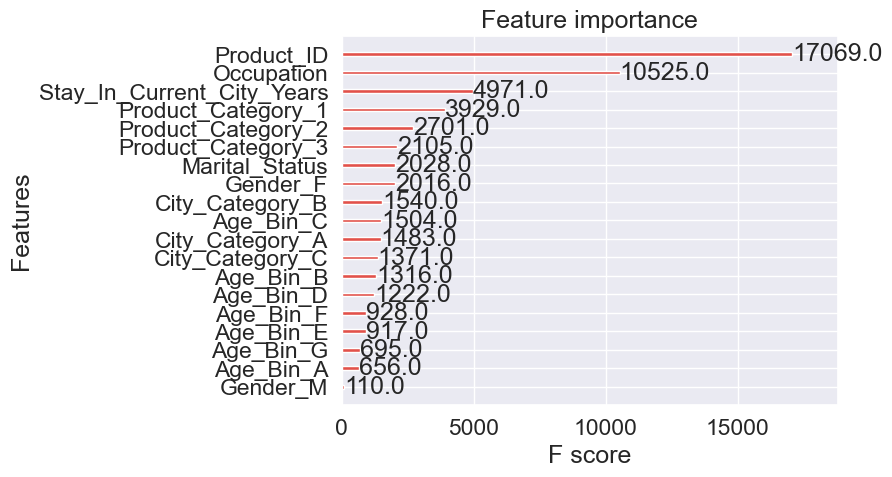

In [42]:
xgboost.plot_importance(xgbm)

From the above analysis, we can conclude that the features "Gender_M", "Age_Bin_A" and "Age_Bin_G" are the three least important features, so we try to remove them to check whether the model will be improved.

In [43]:
df_without_least_features = df_feature.drop(['Gender_M', 'Age_Bin_A', 'Age_Bin_G'], axis=1)
X_train_without_least_features, X_test_without_least_features, y_train_without_least_features, y_test_without_least_features = split_dataset(df_without_least_features)

xgbm_without_least_features = XGBRegressor(n_jobs=-1,
    n_estimators=1000,
    alpha= 3.6353429991712695e-08,
    subsample= 0.9423675532438815,
    colsample_bytree= 0.96,
    min_child_weight= 8,
    eta= 0.3749337530972536,
    gamma= 0.04,
    grow_policy= 'depthwise')

xgbm_without_least_features.fit(X_train_without_least_features, y_train_without_least_features)

pred_without_least_features = xgbm_without_least_features.predict(X_test_without_least_features)
pred_without_least_features[pred_without_least_features<0] = 0

r2_score(pred_without_least_features, y_test_without_least_features)

0.636309291338373

After drop the least 3 important features, the performance of this model has improved a little bit. But the results are random, sometimes good performance and sometimes poor performance, so I decided to keep these features.

### Use auto ml to find the best model

In [44]:
# determine the params to initization h2o
pct_memory=0.5
# psutil：Cross-platform lib for process and system monitoring in Python.
virtual_memory=psutil.virtual_memory()

# min_mem_size: Minimum memory to use for the new H2O server. 
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
port_no=random.randint(5555,55555)


# initialize h2o
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:11267..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.6+9-LTS-190, mixed mode, sharing)
  Starting server from C:\Users\Yi Xu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\YIXU~1\AppData\Local\Temp\tmpvibgj_1v
  JVM stdout: C:\Users\YIXU~1\AppData\Local\Temp\tmpvibgj_1v\h2o_Yi_Xu_started_from_python.out
  JVM stderr: C:\Users\YIXU~1\AppData\Local\Temp\tmpvibgj_1v\h2o_Yi_Xu_started_from_python.err
  Server is running at http://127.0.0.1:11267
Connecting to H2O server at http://127.0.0.1:11267 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.2
H2O_cluster_version_age:    30 days
H2O_cluster_name:           H2O_from_python_Yi_Xu_jgrvnt
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    28 Gb
H2O_cluster_total_cores:    20
H2O_cluster_allowed_cores:  20
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:11267
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.11 final
--------------------------  -----------------------------

In [51]:
# split train set and test set
def split_dataset(data):
    pct_rows=0.80

    df_train, df_test = data.split_frame([pct_rows])

    target = 'Purchase'
    columns=data.columns
    columns.remove(target)
    
    return df_train, df_test, columns, target

# Converting Pandas dataframe in H2O dataframe
hf_feature =h2o.H2OFrame(df_feature) 
# Split dataset
df_train, df_test, columns, target = split_dataset(hf_feature)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [52]:
# max_models: Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models.
max_models=5
h2o = H2OAutoML(max_models=max_models, seed=1)

# Train h2o model
h2o.train(x=columns, y=target, training_frame=df_train)

AutoML progress: |
12:44:38.586: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_2_20230409_124438


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  1/5
# GBM base models (used / total)      1/3
# DRF base models (used / total)      0/1
# GLM base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 5660896.458191625
RMSE: 2379.2638479562593
MAE: 1781.5031051258816
RMSLE: NaN
Mean Residual Deviance: 5660896.458191625
R^2: 0.773558067789296
Null degrees of freedom: 9858
Residual degrees of freedom: 9857
Null deviance: 246468888906.47852
Residual deviance: 55810778181.311226
AIC: 181283.13613453365

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 6671198.32397
RMSE: 2582.8663000569736
MAE: 1916.0261747996565
RMSLE: NaN
Mean Residual Deviance: 6671198.32397
R^2: 0.735984528337442
Null degrees of freedom: 440408
Residual degrees of freedom: 440407
Null deviance: 11128378896153.291
Residual deviance: 2938055782661.3037
AIC: 8170115.771384363

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     1916.03      3.35201      1913.94       1913.71       1921.87       1915.35       1915.26
mean_residual_deviance  6.67121e+06  33122.5      6.64956e+06   6.64664e+06   6.71887e+06   6.69333e+06   6.64765e+06
mse                     6.67121e+06  33122.5      6.64956e+06   6.64664e+06   6.71887e+06   6.69333e+06   6.64765e+06
null_deviance           2.22568e+12  6.66802e+09  2.22742e+12   2.22164e+12   2.22941e+12   2.21648e+12   2.23342e+12
r2                      0.735982     0.00139091   0.736895      0.736477      0.734396      0.734633      0.737507
residual_deviance       5.87611e+11  2.73112e+09  5.86039e+11   5.8545e+11    5.92141e+11   5.88177e+11   5.8625e+11
rmse                    2582.86      6.40755      2578.67       2578.11       2592.08       2587.15       2578.3
rmsle                   nan          0            nan           nan           nan           nan           nan

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [53]:
h2o.leaderboard

model_id                                                    rmse          mse      mae       rmsle    mean_residual_deviance
-------------------------------------------------------  -------  -----------  -------  ----------  ------------------------
StackedEnsemble_AllModels_1_AutoML_2_20230409_124438     2582.87  6.6712e+06   1916.03  nan                      6.6712e+06
StackedEnsemble_BestOfFamily_1_AutoML_2_20230409_124438  2582.87  6.67124e+06  1916.03  nan                      6.67124e+06
GBM_1_AutoML_2_20230409_124438                           2584.11  6.67762e+06  1917.47  nan                      6.67762e+06
GBM_3_AutoML_2_20230409_124438                           2666.38  7.10957e+06  1998.99  nan                      7.10957e+06
GBM_2_AutoML_2_20230409_124438                           2694.67  7.26124e+06  2020.71  nan                      7.26124e+06
DRF_1_AutoML_2_20230409_124438                           2708.19  7.3343e+06   2017.05    0.355445               7.3343e+06
GLM_1_AutoML_2_20230409_124438                           5026.74  2.52681e+07  4074.02    0.765268               2.52681e+07
[7 rows x 6 columns]

In [54]:
# From the leaderboard attribute, we can get the top 7 models that have great performance on prediction. Also, I can choose the best model based on the algorithm I want to use. 
best_GBM_model = h2o.get_best_model(algorithm="gbm")
#  Evaluating the model on Test Data
best_GBM_model.model_performance(df_test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 6595462.752205468
RMSE: 2568.1633032588616
MAE: 1903.992224433594
RMSLE: NaN
Mean Residual Deviance: 6595462.752205468

## Step4: Model Interpretibility

From the content above, I utilized the XGBoost and AutoML framework to train the prediction model, so Let me try to interpret models in the following section.

### XGBoost Model

Use plotting module to plot importance and output tree.

From the plot below, given the xgboost model we trained, the top 3 important features are including Product_ID, Occupation and Stay_In_Current_City_Years.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

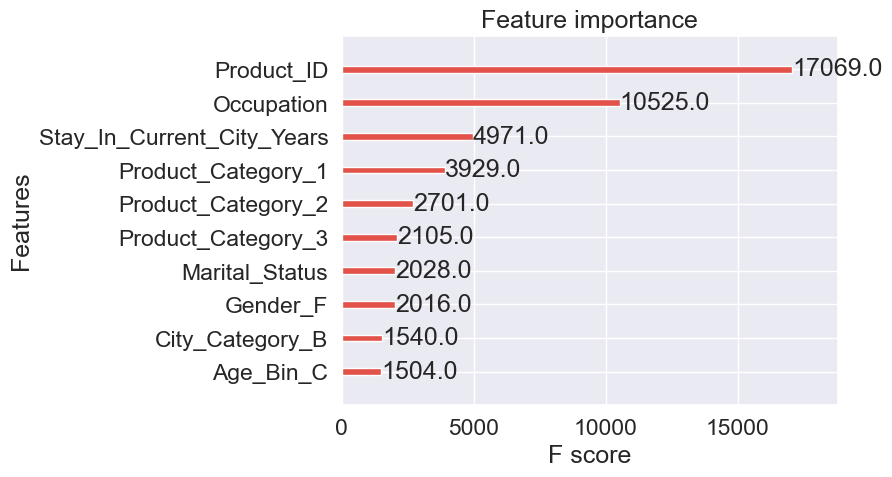

In [55]:
xgboost.plot_importance(xgbm, max_num_features=10)

#### Interpret using SHAP values

In [57]:
xgb_explainer = shap.TreeExplainer(xgbm)
xgb_shap_values = xgb_explainer(X_test, check_additivity=False)

-  Global Interpretability
#### 1. Variable Importance Plot
We can conclude that Product_Category_1, Product_ID, Product_Category_2 and Occupation are the top4 important features.

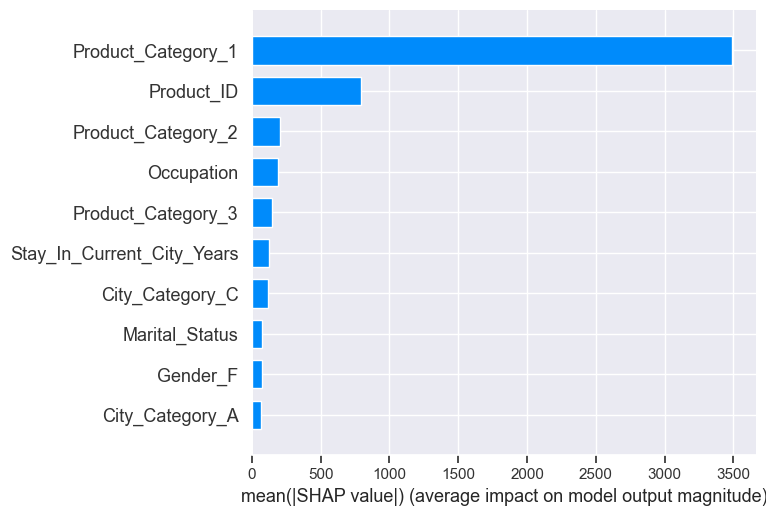

In [58]:
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar",max_display=10)

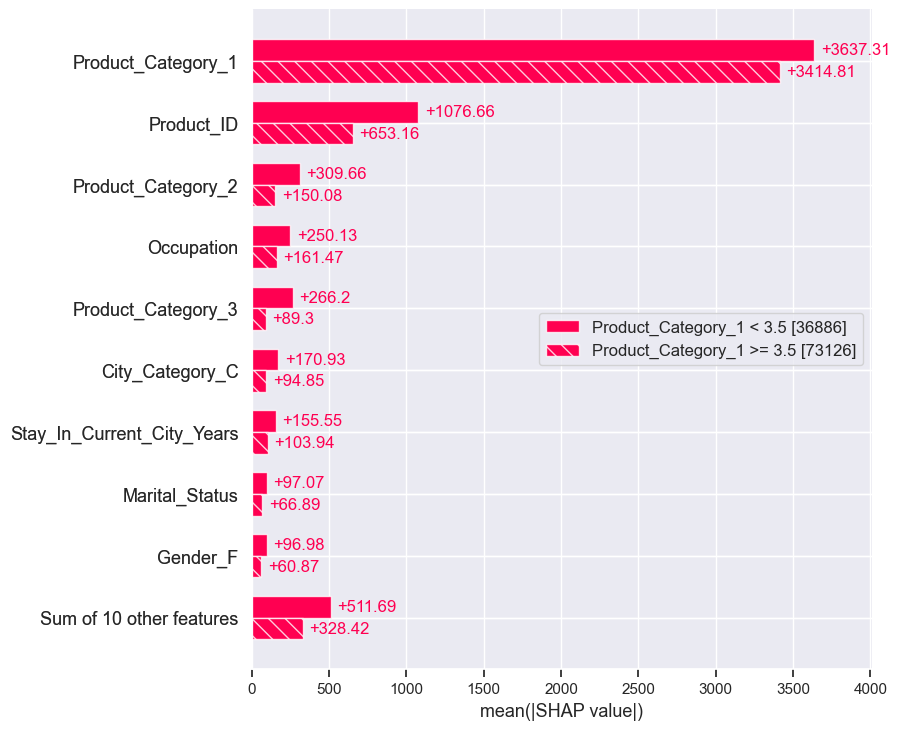

In [59]:
shap.plots.bar(xgb_shap_values.cohorts(2).abs.mean(0))

#### 2. Heatmap Plot

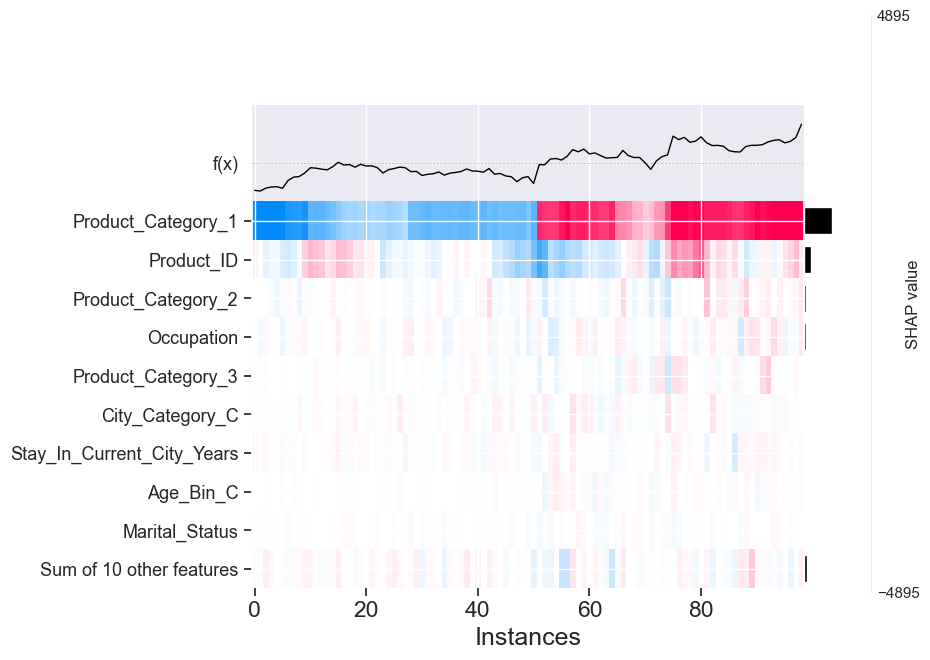

In [60]:
shap.plots.heatmap(xgb_shap_values[1:100])

#### 3. Summary Plot

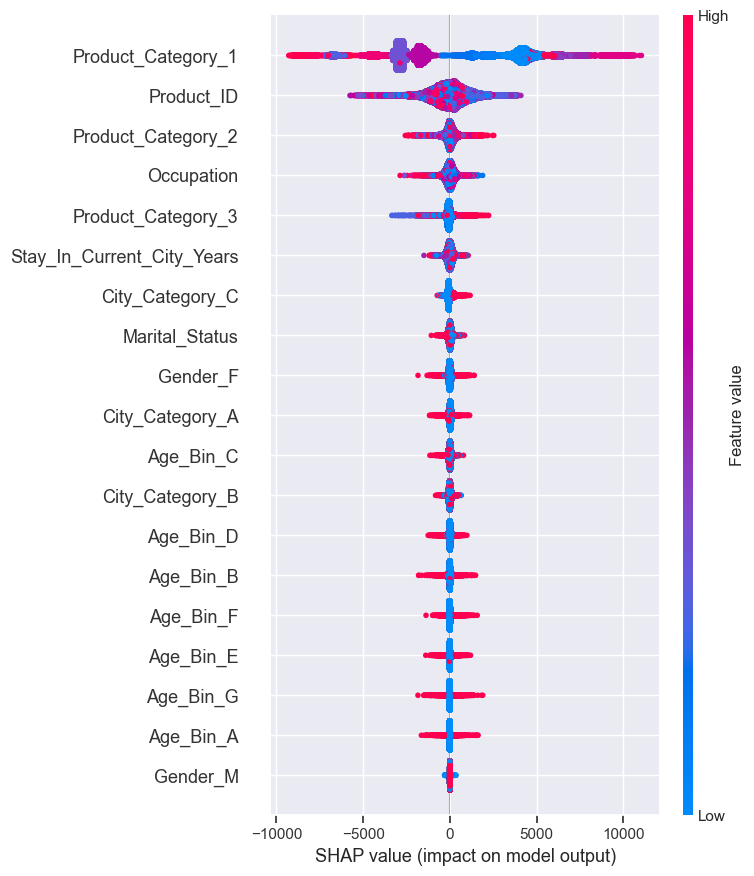

In [61]:
shap.summary_plot(xgb_shap_values, X_test)

- Local Interpretability
#### 1. Individual Waterfall Plot
For this observation, f(x) = 14011.574 is what we got as a model output and the expected output for this sample was 9262.935. We can conclude that "Product_Category_1" has the biggest and most positive impact by "=2641.12" for this specific sample. Followed by "Product_ID" had a positive impact and it brought the amount of "Purchase" up by "+1850.25" for this sample, and so on. 

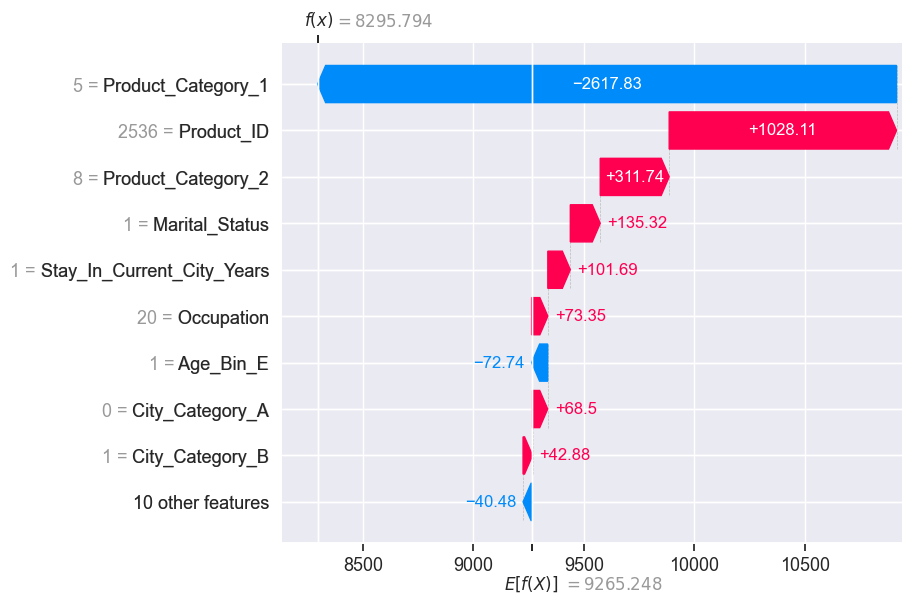

In [62]:
sample_index = 780
shap.plots.waterfall(xgb_shap_values[sample_index])

#### 2. Individual Heatmap Plot

In [64]:
# Initialize Jupyter notebook with initjs(), otherwise will get an error message.
shap.initjs()

def shap_force_plot(j):
    p = shap.force_plot(xgb_explainer.expected_value, xgb_shap_values.values[j,:], X_test.iloc[j,:])
    
    return(p)

shap_force_plot(sample_index)

### H2o AutoML

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

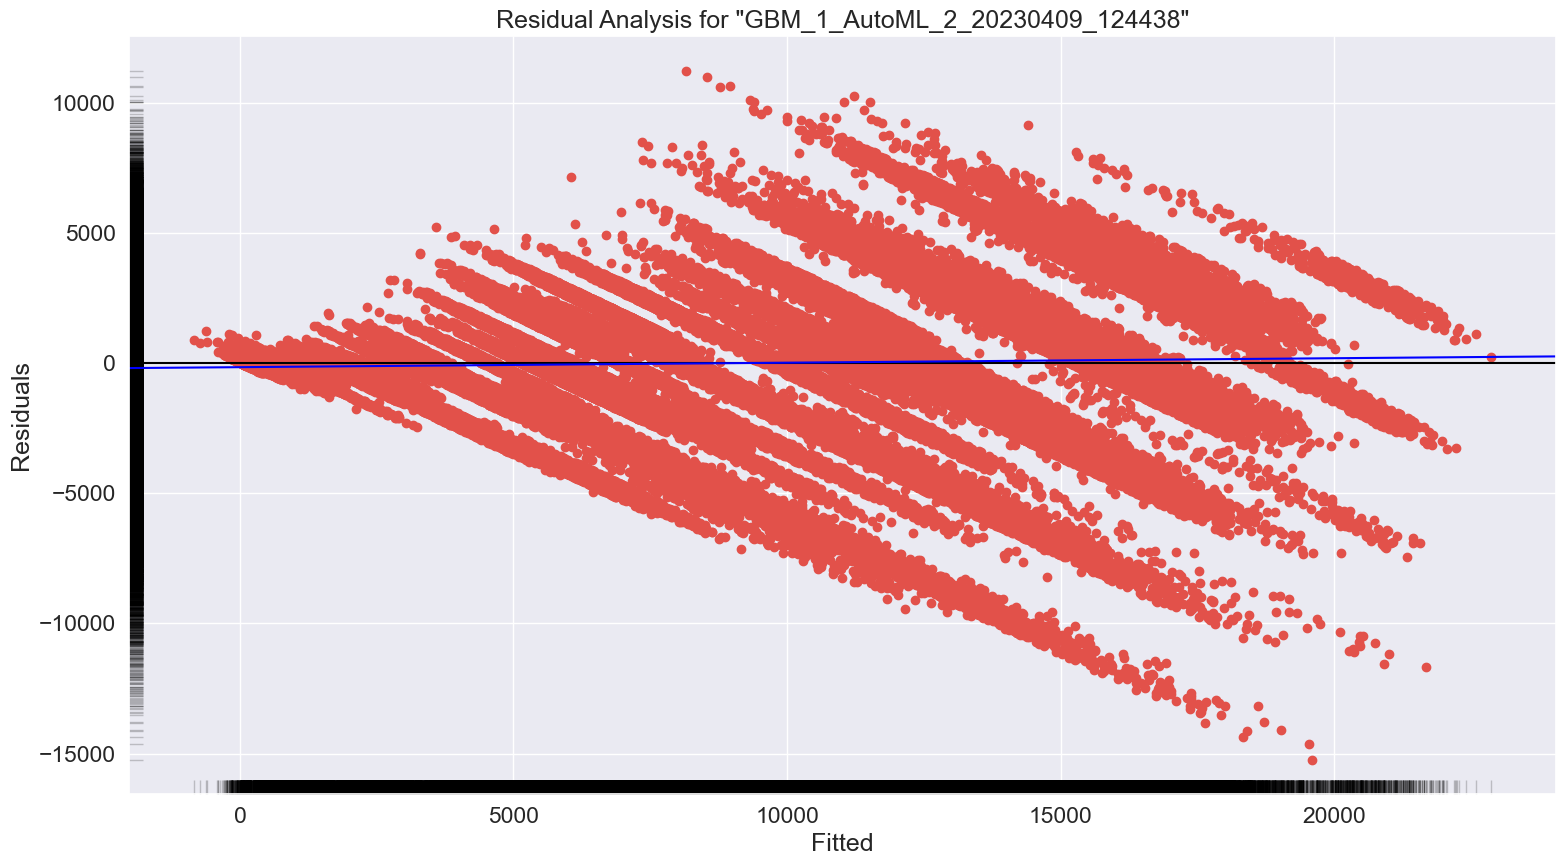

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

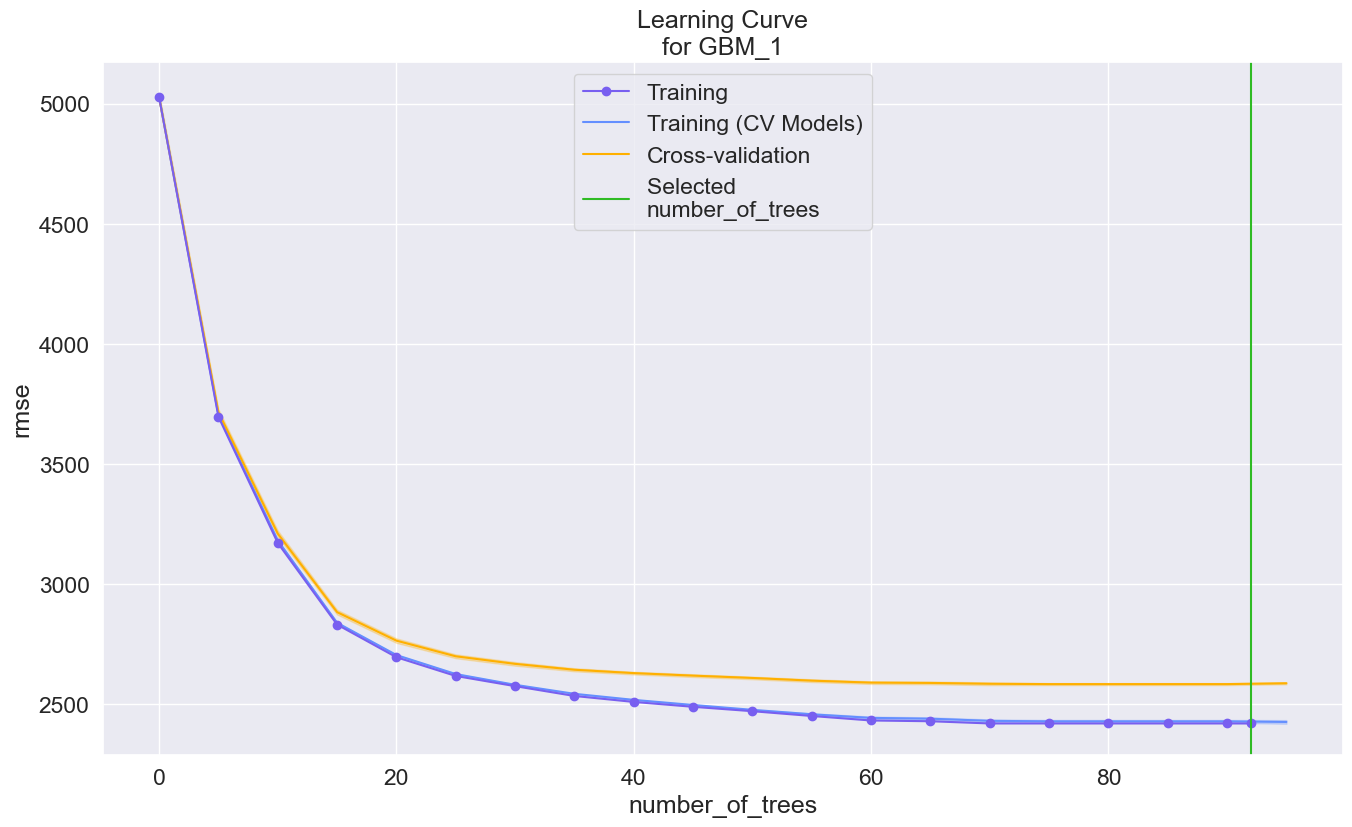

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

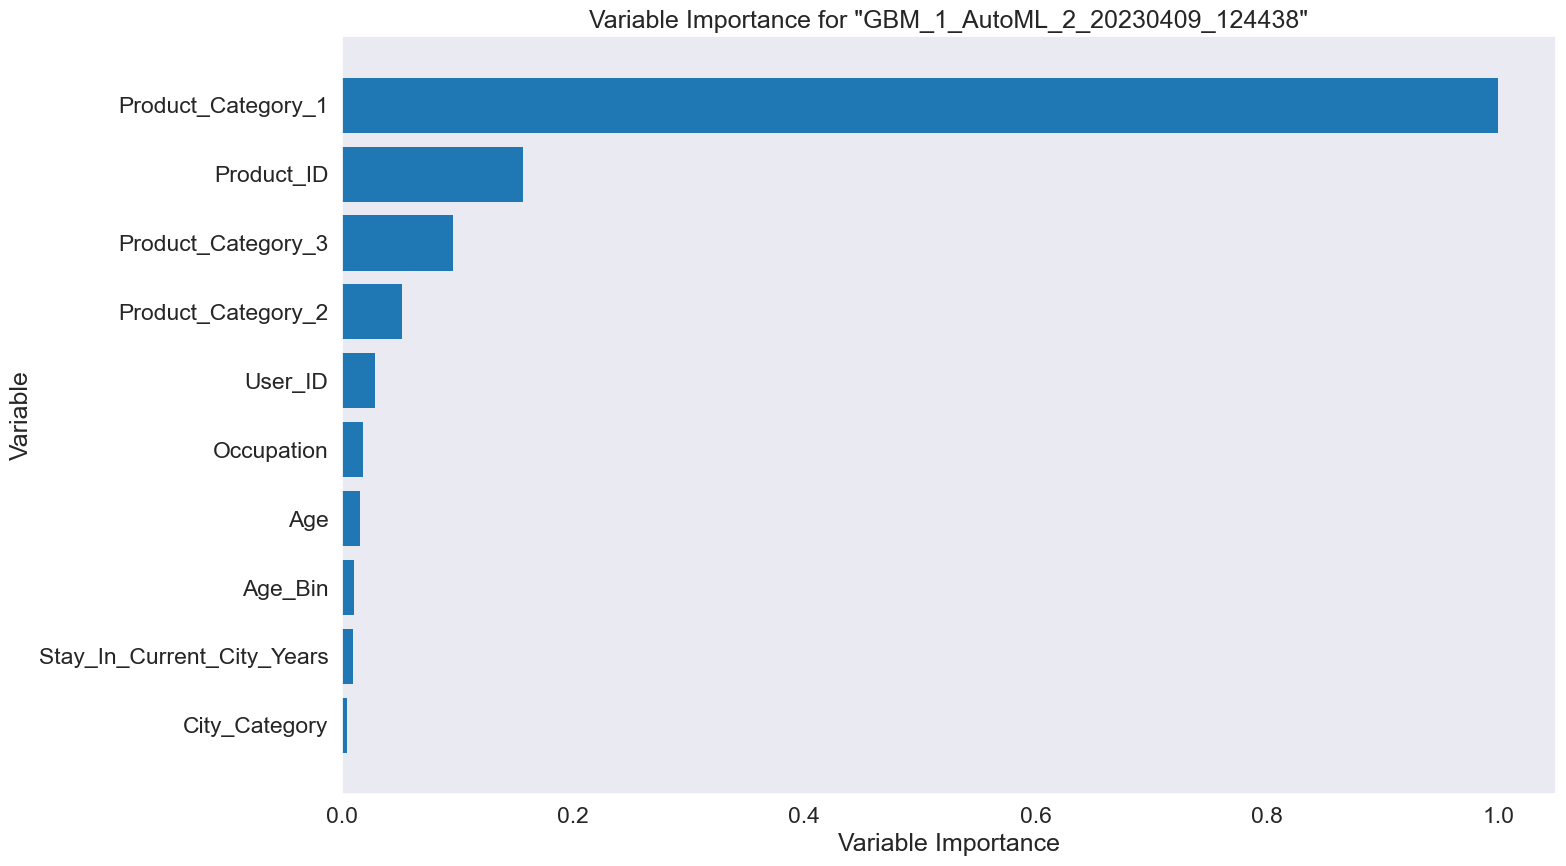

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

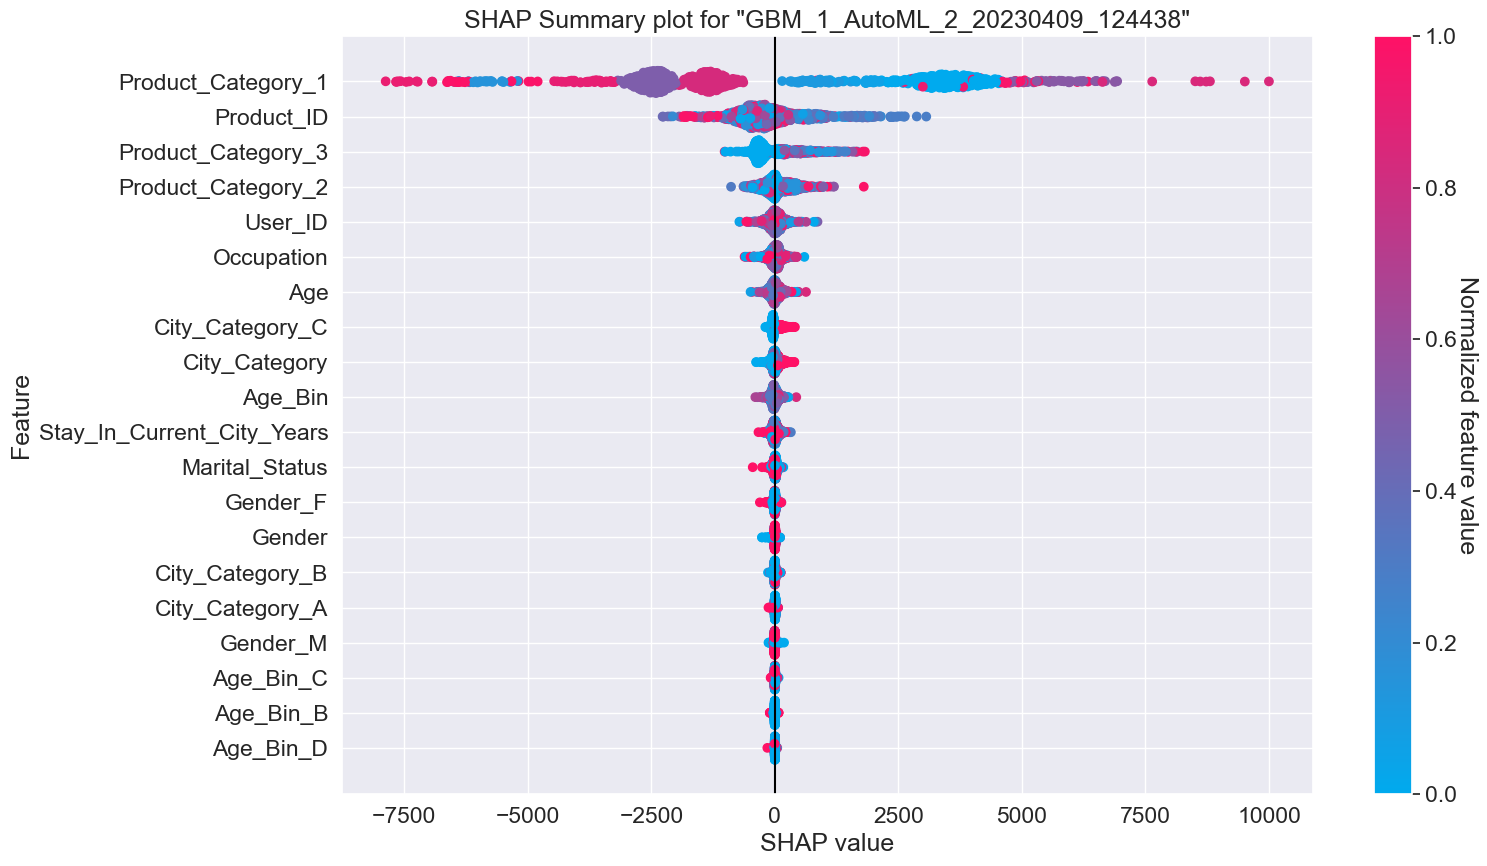

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

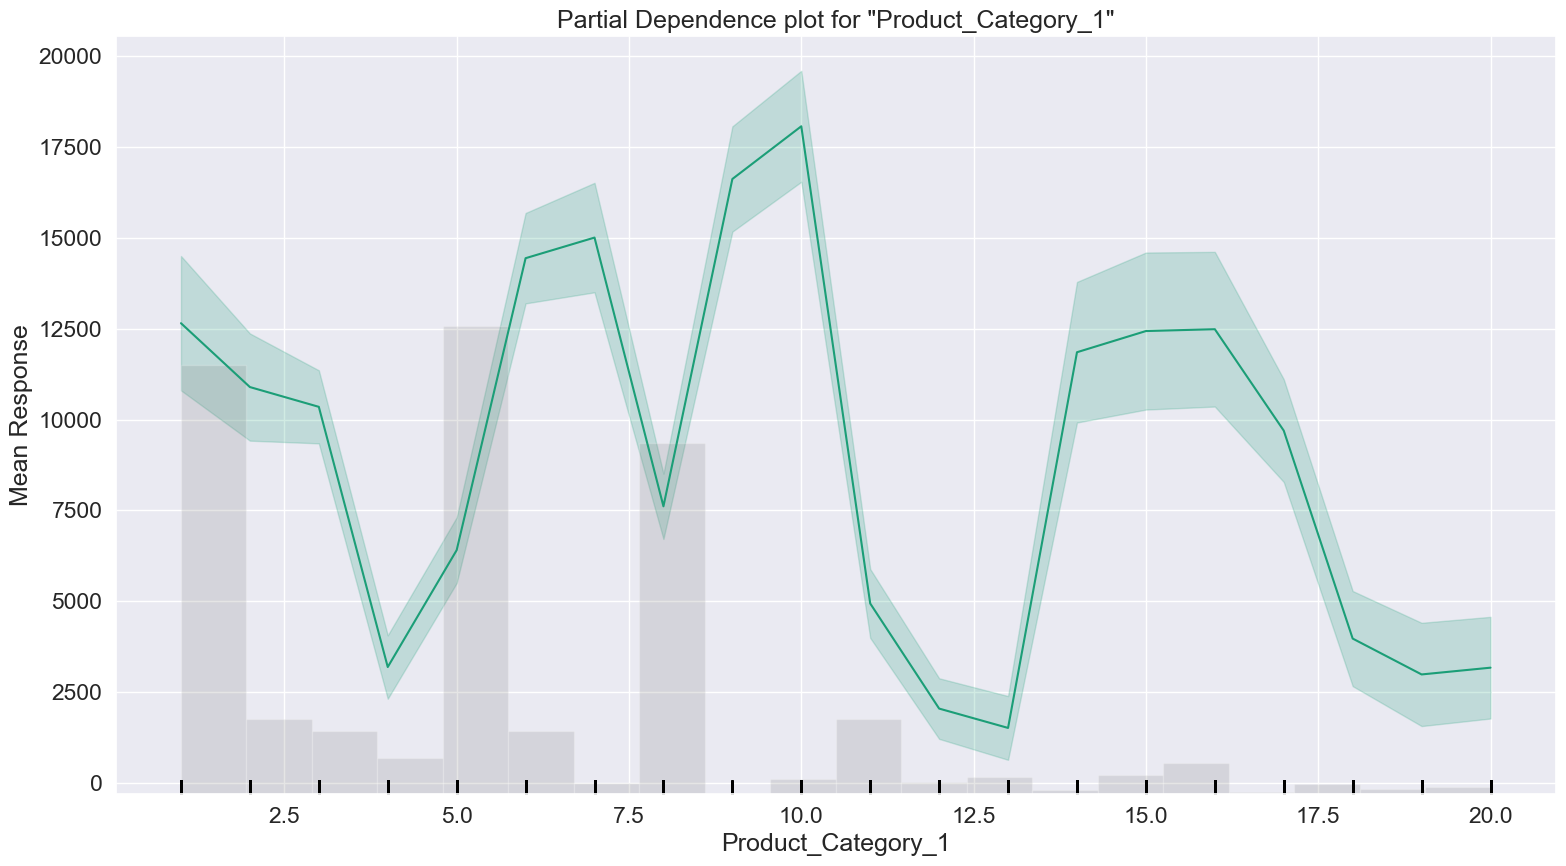

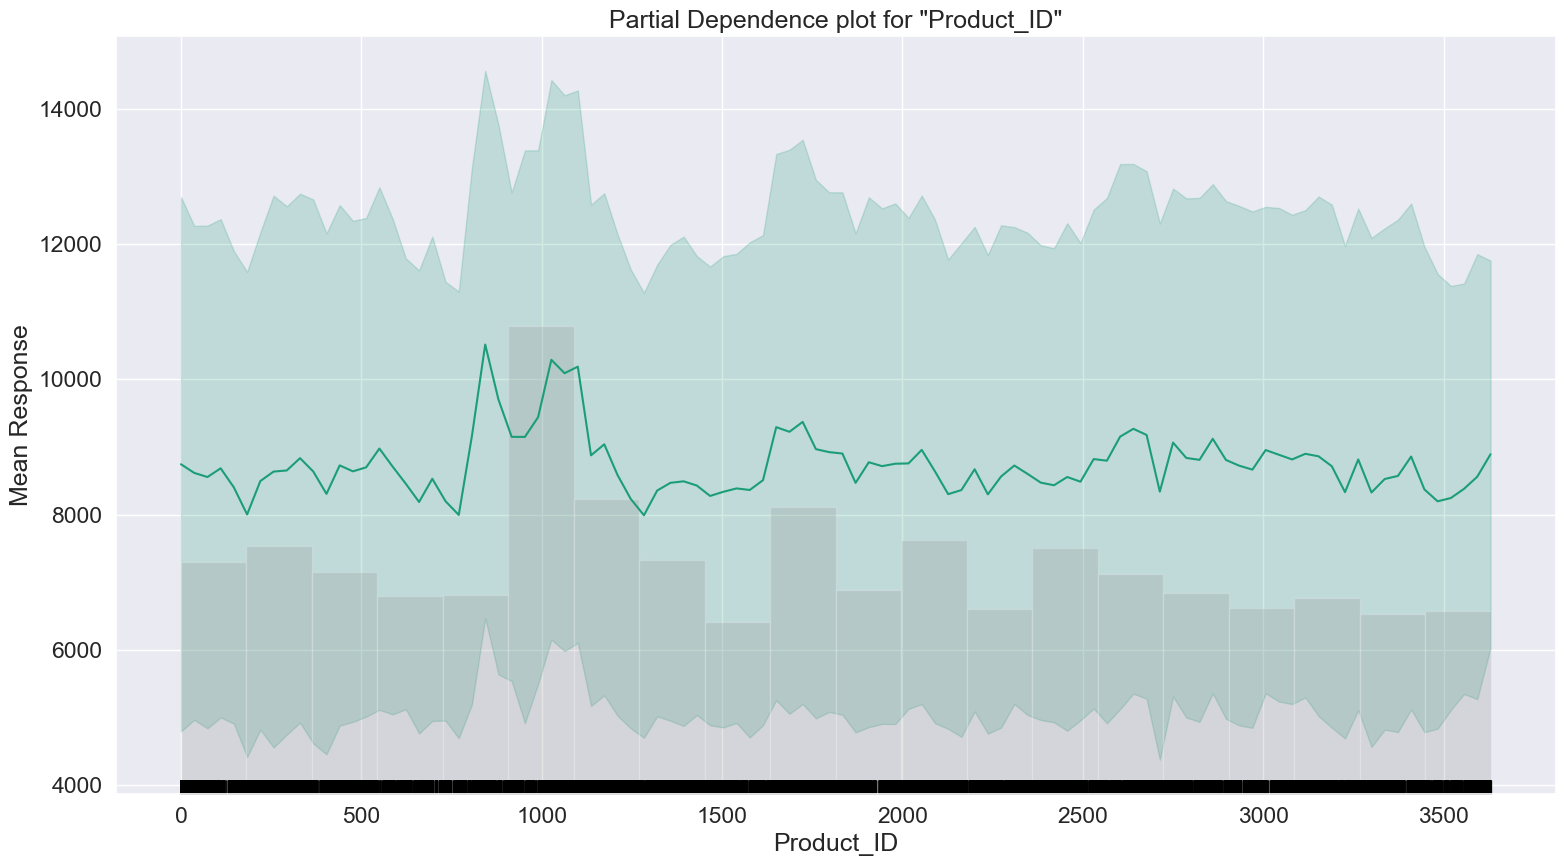

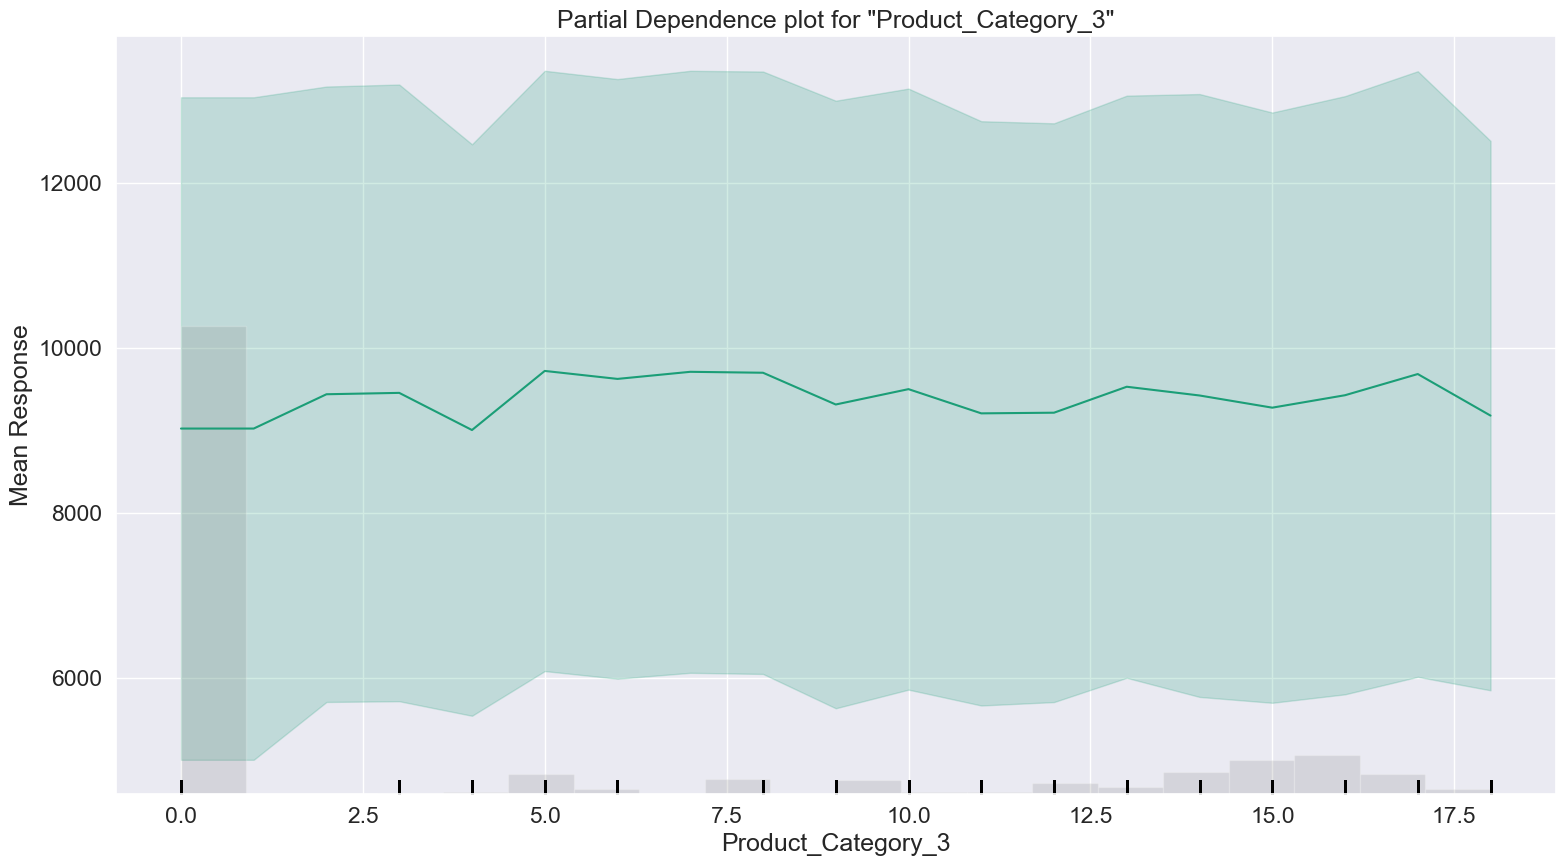

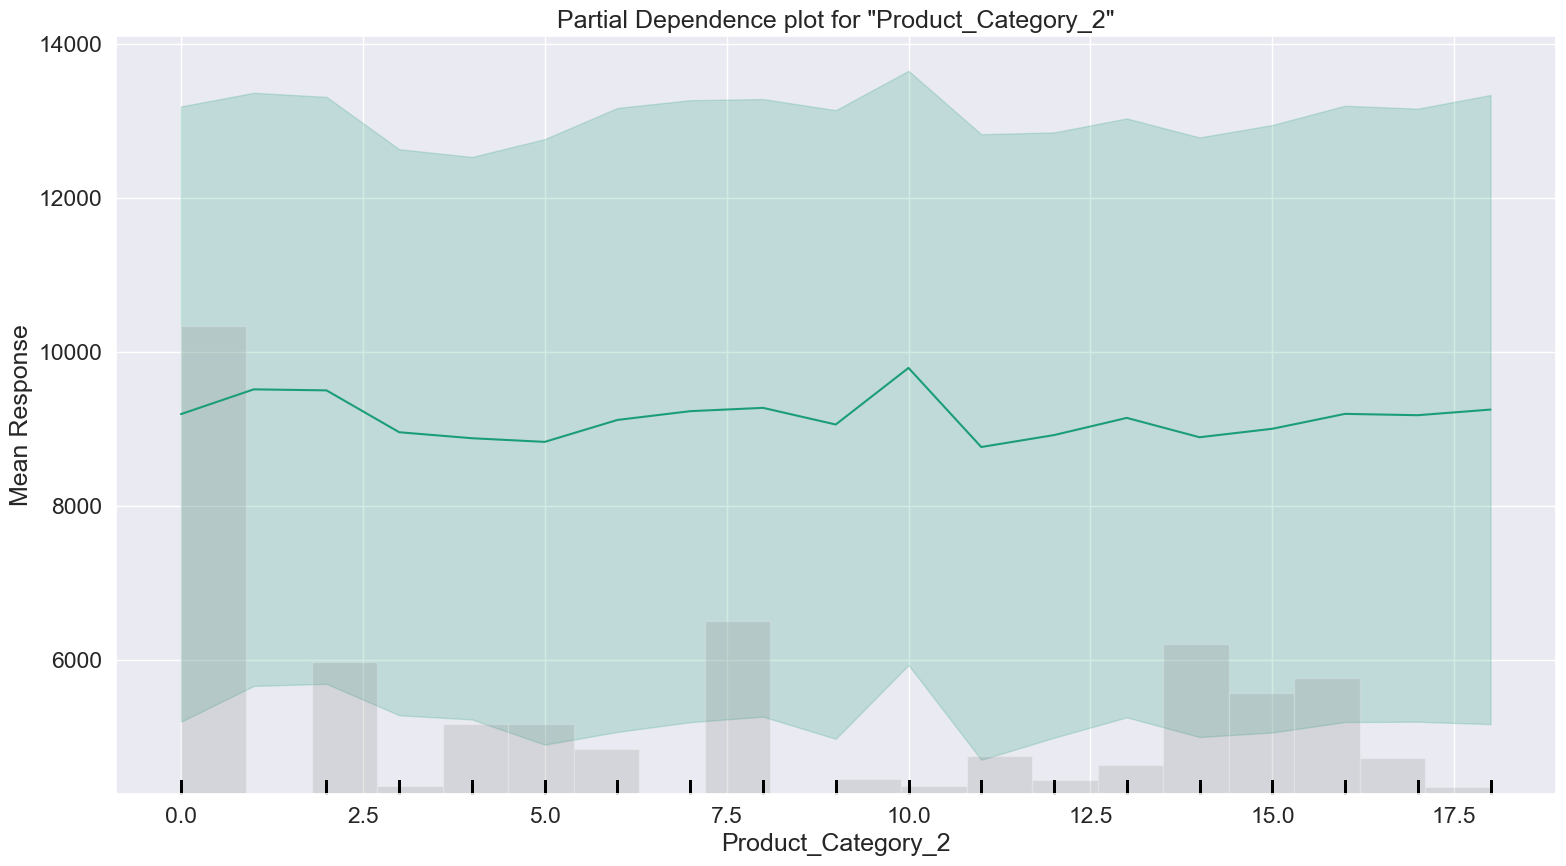

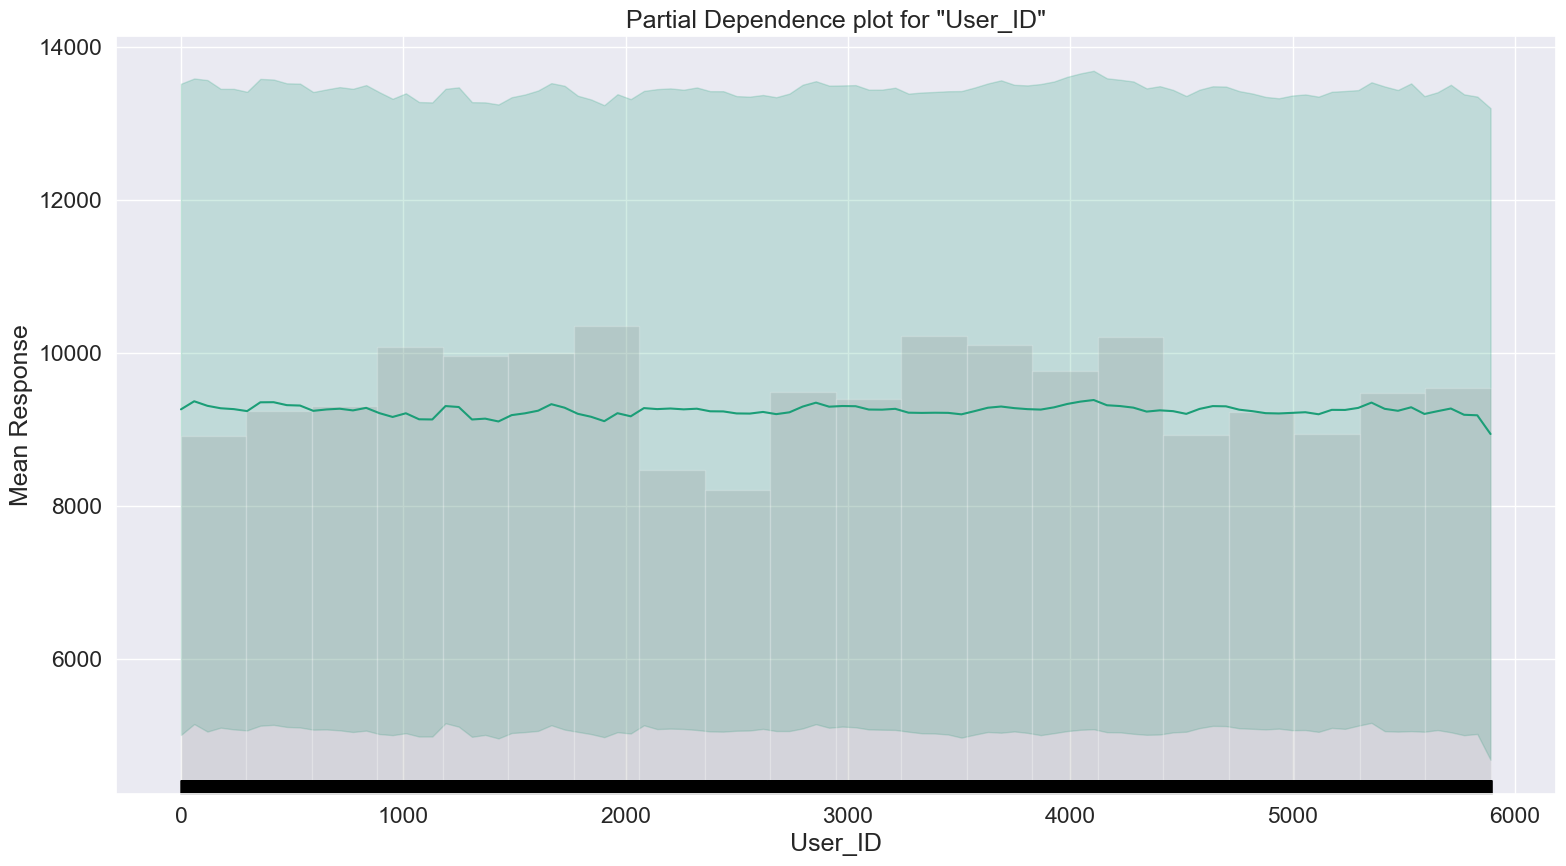

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

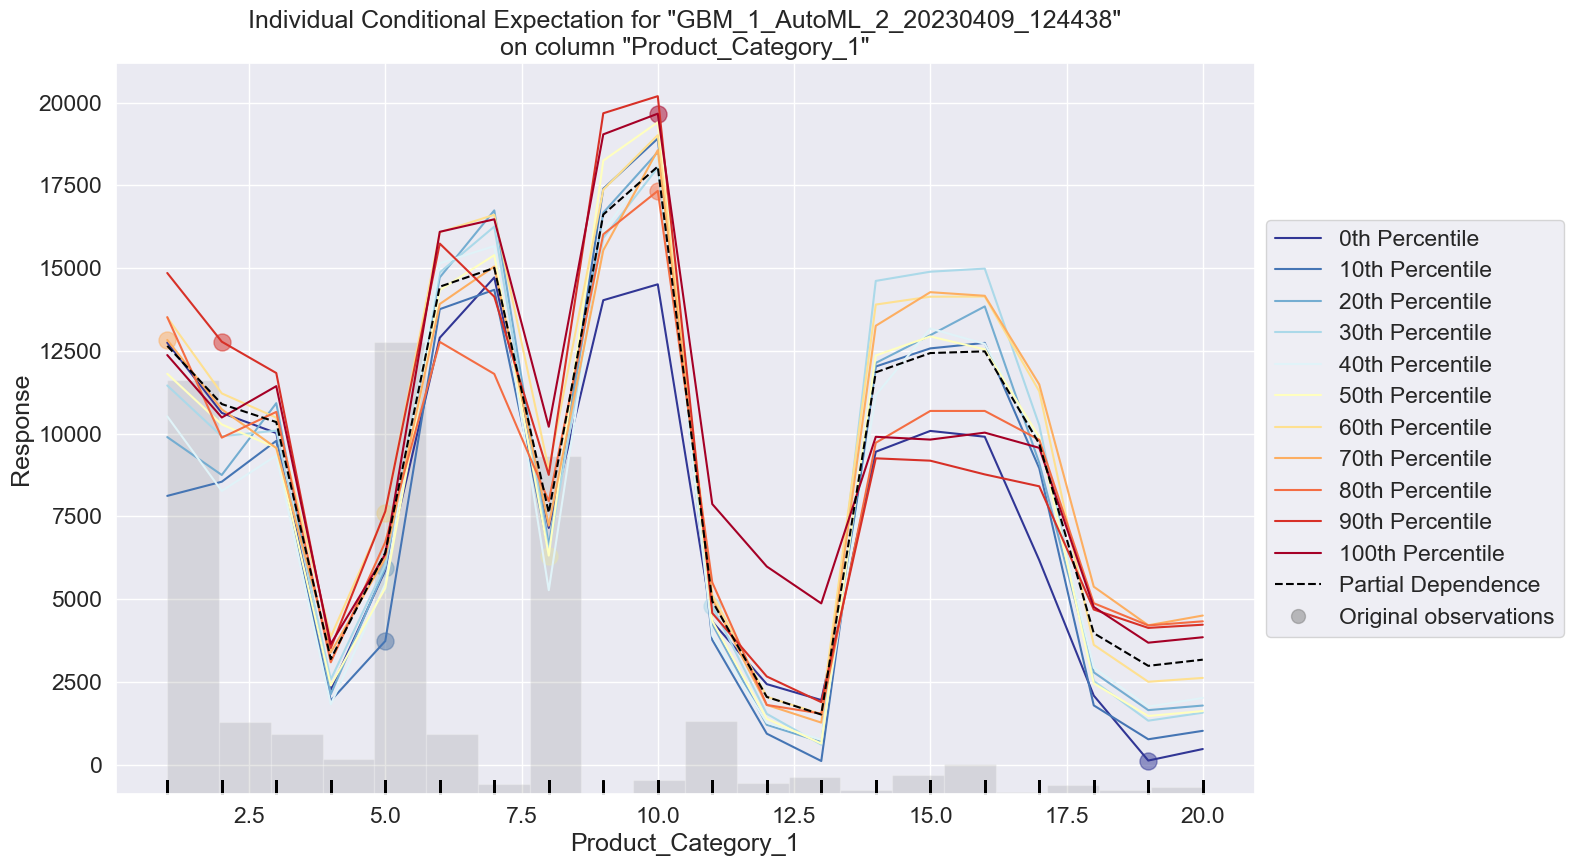

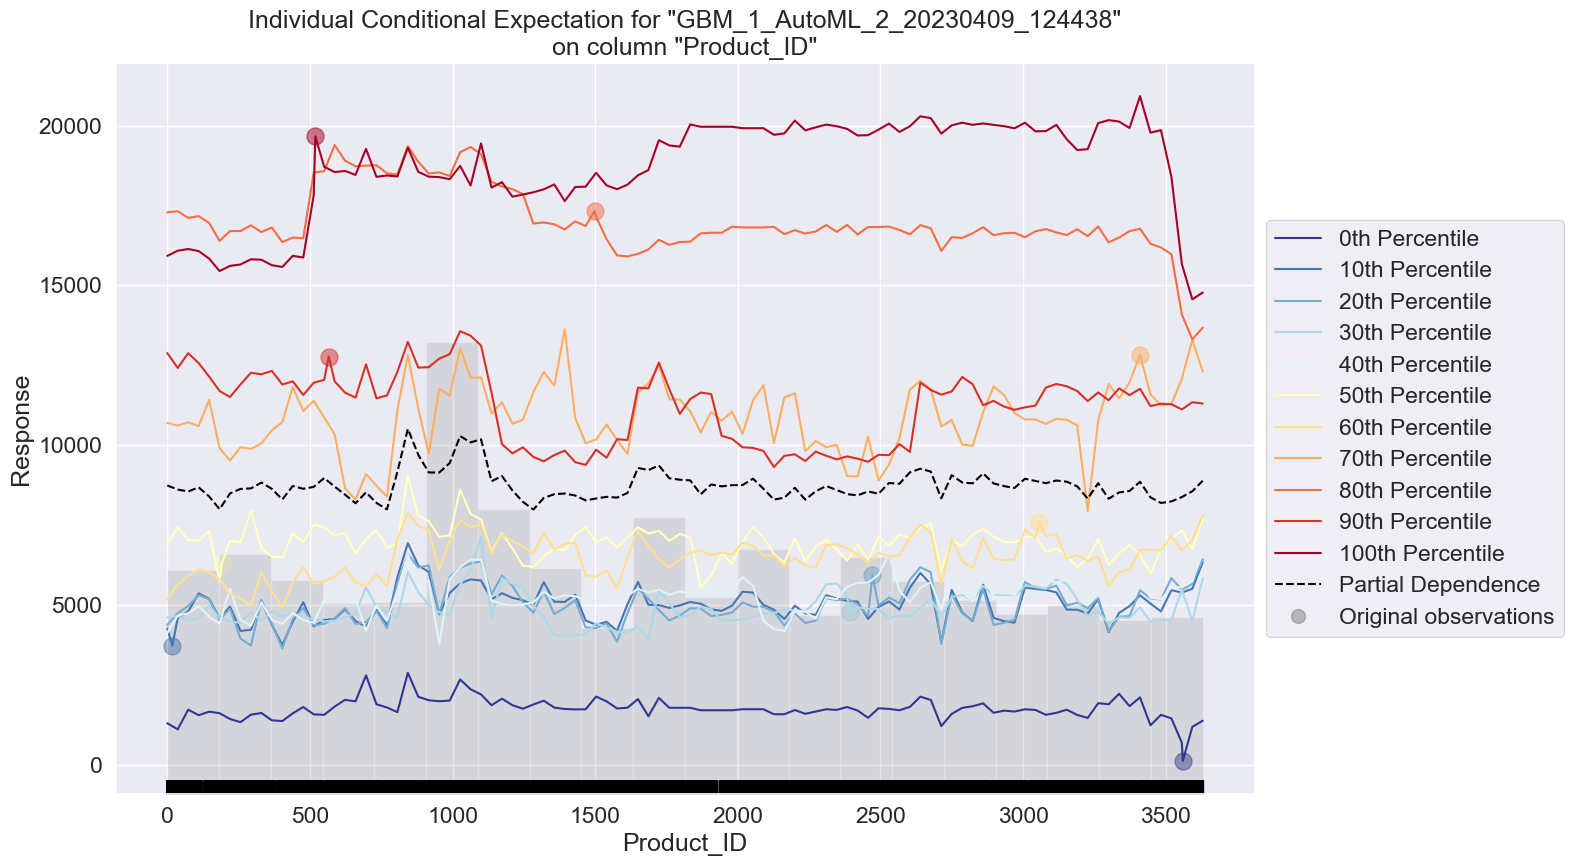

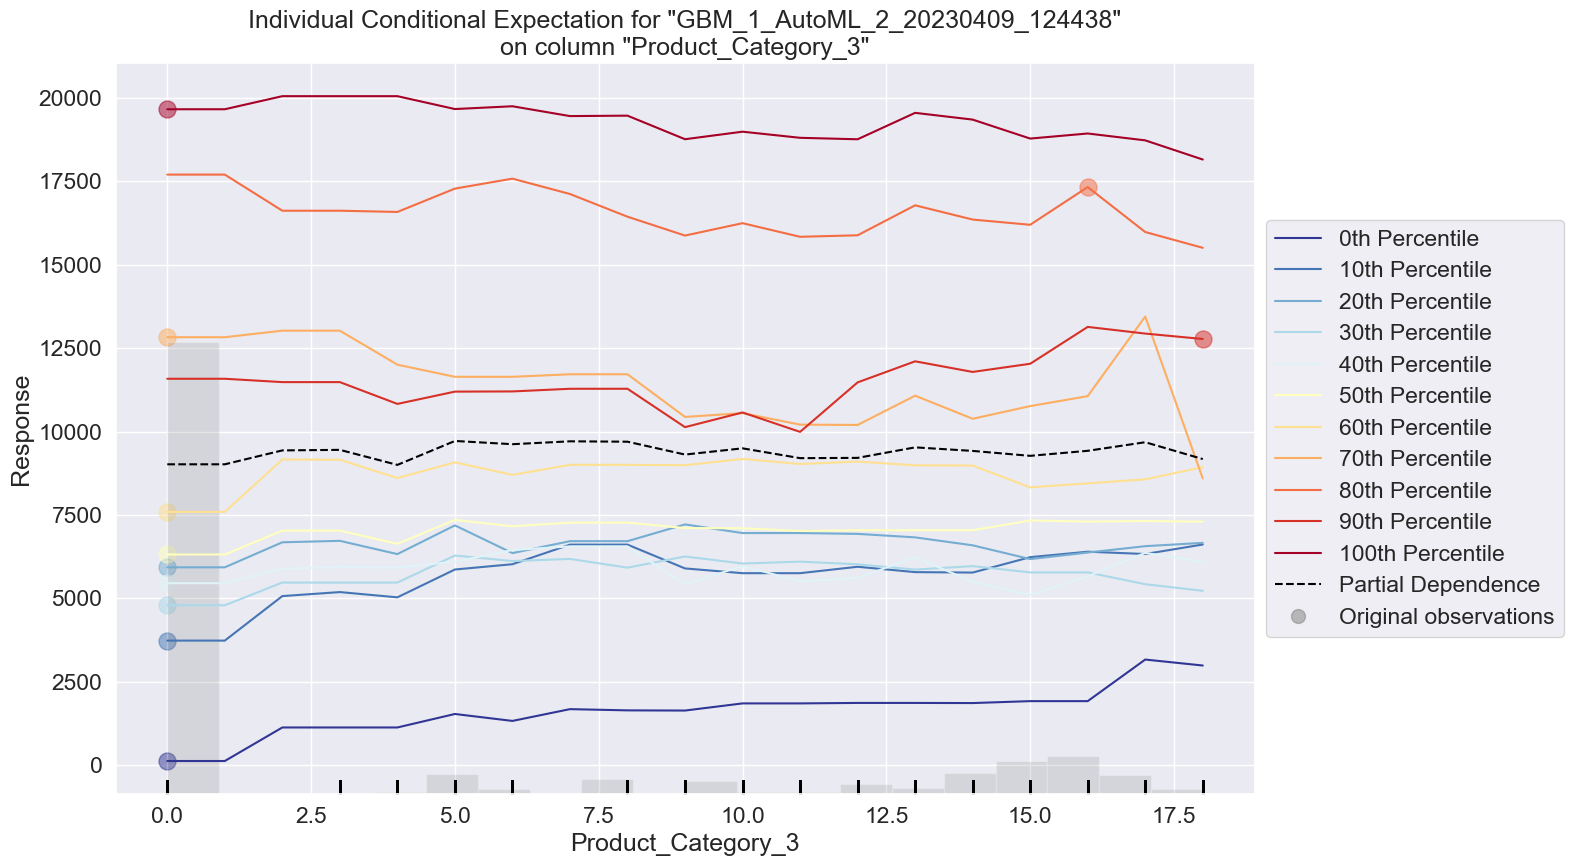

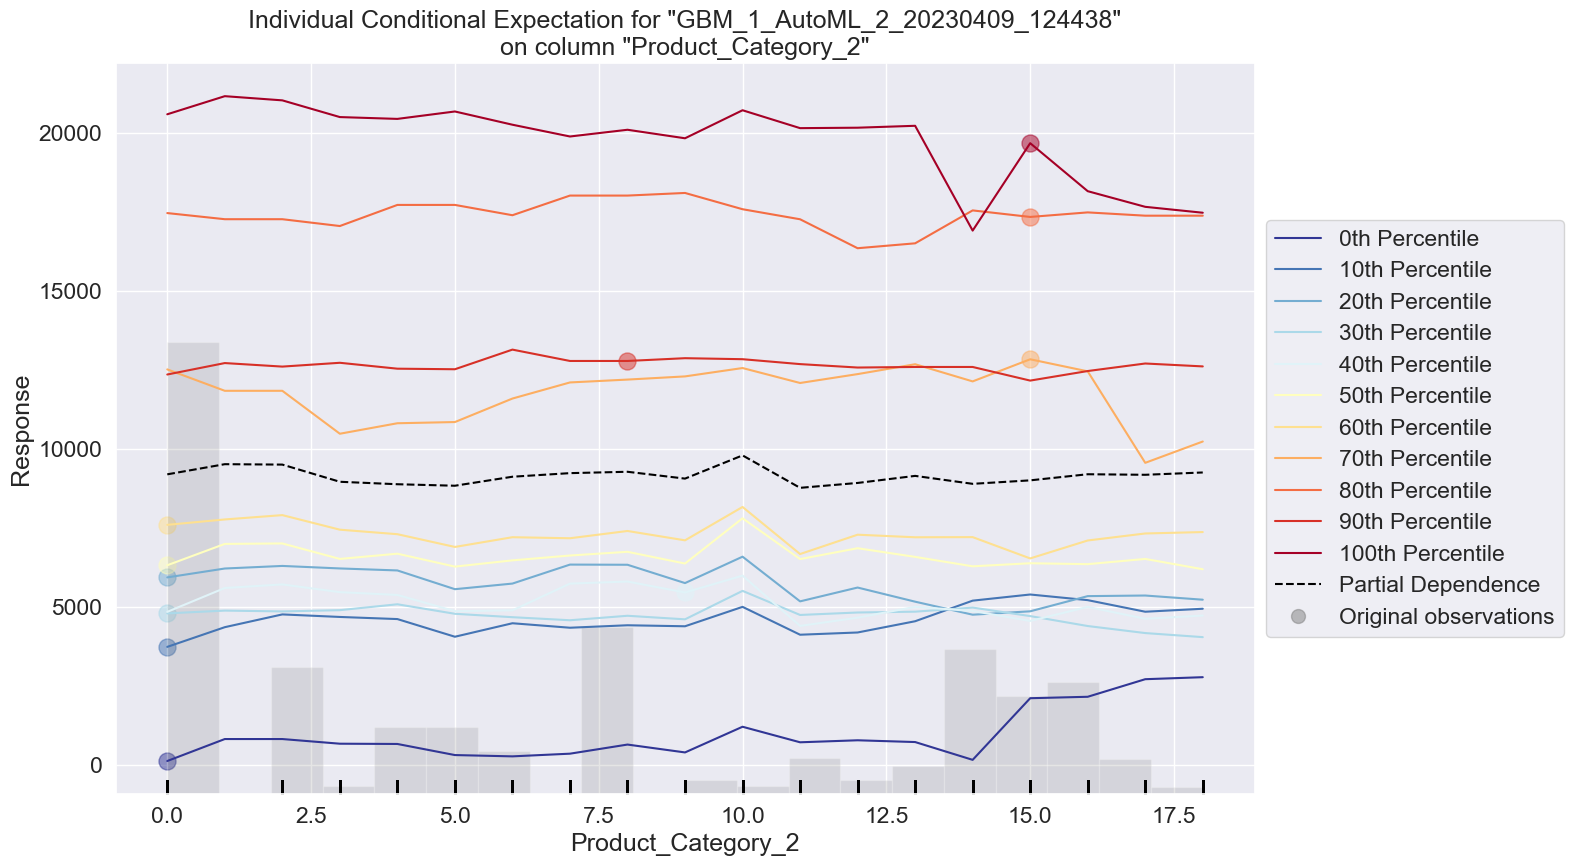

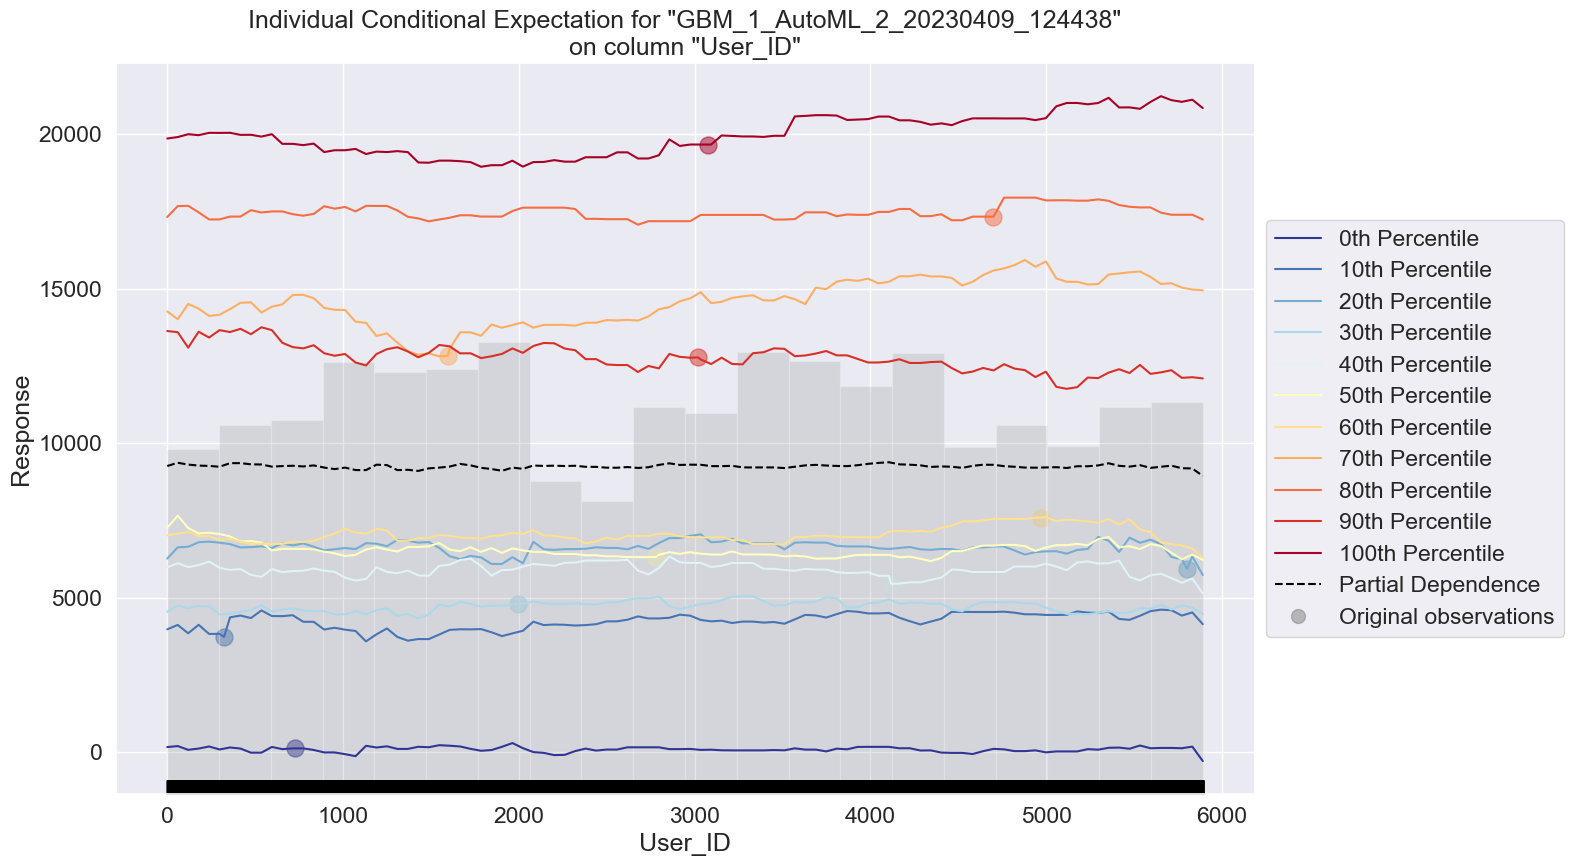

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [65]:
# get the explaination of the best model -- globlely
best_GBM_model.explain(df_test)

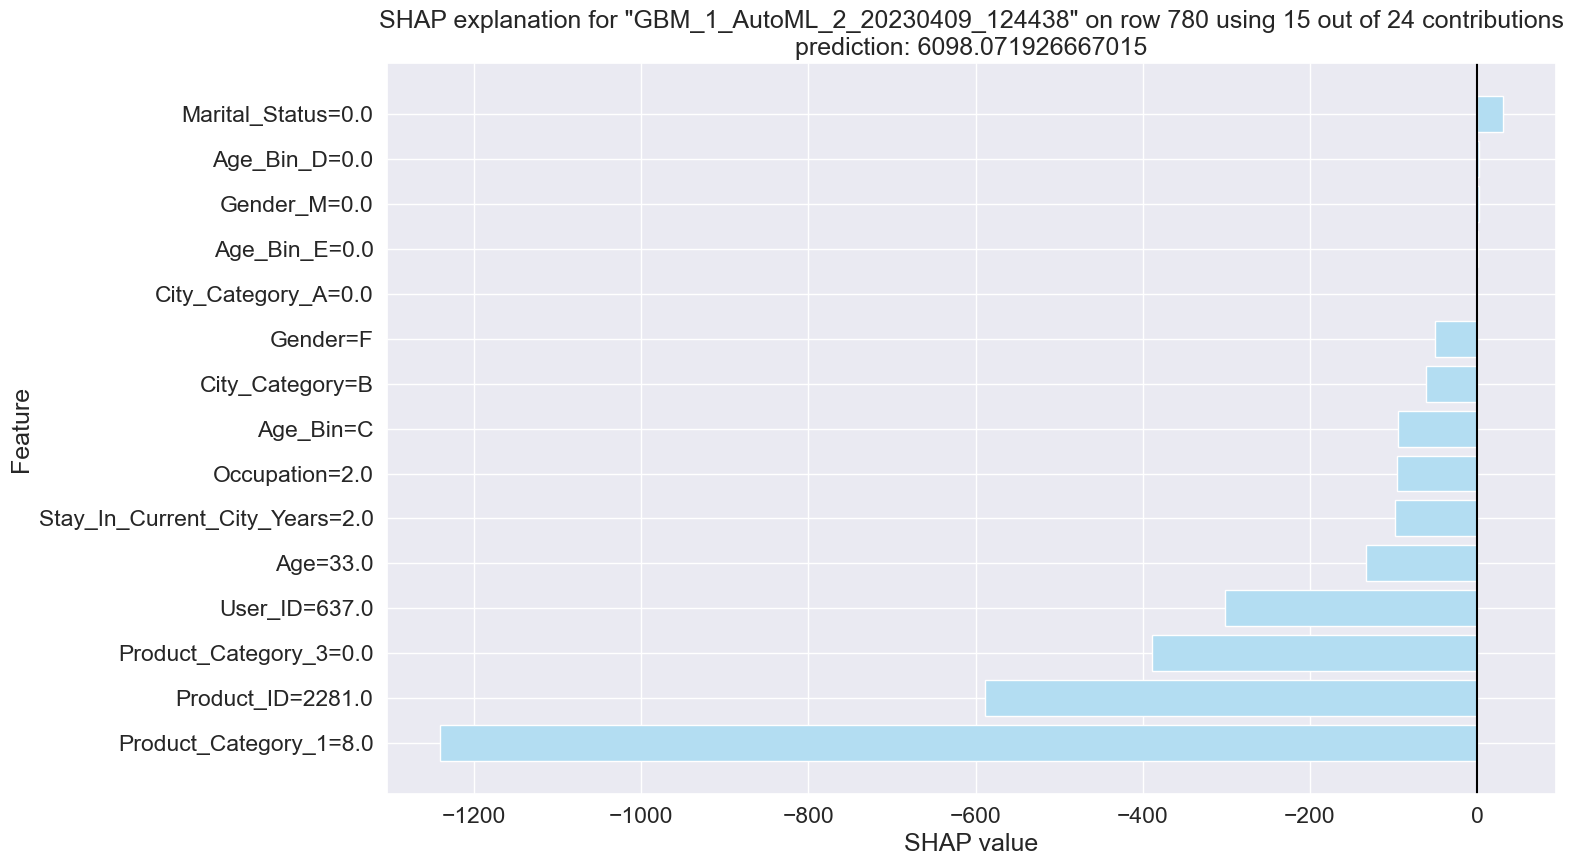

In [66]:
# Individually analyze certain observation
best_GBM_model.shap_explain_row_plot(df_test, sample_index)

The plot above shows the contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model. In this observation, Product_Category_1,Product_ID and Product_Category_2 are vital for prediction.

## Conclusion
In this assignment, I focused on readability and clarity and I finished the data analyse, feature engineering, modeling and model intepretation.

## License
MIT License
Copyright (c) 2023 Mingxia Li

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Citation
- [The 5 Feature Selection Algorithms every Data Scientist should know](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
- [Explain Your Model with the SHAP Values](https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d)